In [147]:
# !pip3 install shap
# !pip3 install pyexplainer
# !pip3 install lime
# !pip3 install gensim
# !pip3 install keras
# !pip3 install tensorflow
# !pip3 install sklearn
# !pip3 install nltk
# import nltk
# nltk.download('omw-1.4')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# !pip install wordcloud

In [148]:
import numpy as np
import json, re, nltk, string, os, sys
from os.path import abspath
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
from gensim.models import Word2Vec
from keras.preprocessing import sequence
from keras.models import Model,Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import RMSprop
from keras.utils import np_utils
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline

from lime import lime_tabular
from lime import lime_text
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
import time

In [149]:
bug_reports = os.path.join(sys.path[0],"data/MozillaFirefox/train_test_json/classifier_data_20.json")
deep_data = os.path.join(sys.path[0],"data/MozillaFirefox/deep_data.json")

In [150]:
#========================================================================================
# Initializing Hyper parameter
#========================================================================================
#1. Word2vec parameters
min_word_frequency = 5
embed_size_word2vec = 300
context_window_word2vec = 5

#2. Classifier hyperparameters
numCV = 10
max_sentence_len = 50
min_sentence_length = 15
rankK = 10
batch_size = 32

In [151]:
def contains_letters(phrase):
    return bool(re.search('[a-zA-Z]', phrase))

In [152]:
def getProcessedData(bug_reports):
    with open(bug_reports) as data_file:
        data = json.load(data_file, strict=False)

#     i = 0
    
    raw_data = []
    all_data = []
    all_owner = []
    for item in data:
        
        data = 'Title:' + item['issue_title'] + '\n Description: ' + item['description']
        raw_data.append(data) 

        #1. Remove \r
        current_title = item['issue_title'].replace('\r', ' ')
        current_desc = item['description'].replace('\r', ' ')

        #2. Remove URLs
        current_desc = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', current_desc)

        #3. Remove Stack Trace
        start_loc = current_desc.find("Stack trace:")
        current_desc = current_desc[:start_loc]

        #4. Change to lower case & Remove hex code
        current_data = current_title.lower() + ' ' + current_desc.lower()
        current_data = re.sub(r'(\w+)0x\w+', ' ', current_data)
        current_data = re.sub(r'[^\w\s]', ' ', current_data)
        
        #5. Remove digits
        current_data = re.sub(r'[0-9]', '', current_data)

        #6. Tokenize
        current_data_tokens = [w for w in nltk.word_tokenize(current_data) if contains_letters(w) and len(w) > 1]

        #7. Remove stop words
        stop_words = set(stopwords.words('english'))
        current_data_filter = [w for w in current_data_tokens if not w in stop_words]

        all_data.append(current_data_filter)
        all_owner.append(item['owner'])
        
#         i = i + 1
#         if i == 20000:
#             break

    return raw_data, all_data, all_owner

In [153]:
raw_data, all_data, all_owner = getProcessedData(bug_reports)

In [154]:
len(raw_data)
len(all_data)
len(all_owner)

20417

In [155]:
def getRandomForestClassifierAccuracy(X_train, Y_train, X_test, Y_test):
    start = time.time()

    rfc_model = RandomForestClassifier(n_estimators = 1000, max_depth = 300, n_jobs = -1, random_state=1)
    
    rfc_model.fit(X_train, Y_train) 
    
    y_pred = rfc_model.predict_proba(X_test)
    
    end = time.time()
    
    elapsedTime = end - start
    
    classes = rfc_model.classes_
    sortedIndices = []
    pred_classes = []
    index_pred_classes = []
    rfc_accuracy = []
    index = 0  
    for ll in y_pred:
        sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))  
    for k in range(1, rankK+1):
        id = 0
        trueNum = 0
        pred_class_no=0
        for sortedInd in sortedIndices:
            if Y_test[id] in classes[sortedInd[:k]]:
                trueNum += 1
                pred_classes.append(classes[sortedInd[:k]])
                pred_class_no = trueNum
                if index < 9 and k == 1:
                    index = id
                    index_pred_classes.append(classes[sortedInd[:k]])
            id += 1
        rfc_accuracy.append(float('{0:.2f}'.format((float(trueNum) / len(y_pred)) * 100)))

    return rfc_model, rfc_accuracy, classes, index, elapsedTime

In [156]:
def getMLPClassifierAccuracy(X_train, Y_train, X_test, Y_test):
    start = time.time()
    
    mlp_classifier = MLPClassifier(solver='adam', hidden_layer_sizes=(150,), random_state=1)
    
    mlp_classifier.fit(X_train, Y_train)
    
    y_pred = mlp_classifier.predict(X_test)
#     print('MLP Accuracy Score : {0:0.2f}'.format(accuracy_score(Y_test, y_pred)))
    
    y_pred_proba = mlp_classifier.predict_proba(X_test)
    
    end = time.time()
    
    elapsedTime = end - start

    classes = mlp_classifier.classes_
    sortedIndices = []
    pred_classes = []
    m_accuracy = []
    index = 0  
    for ll in y_pred_proba:
        sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))  
    for k in range(1, rankK+1):
        id = 0
        trueNum = 0
        for sortedInd in sortedIndices:
            if Y_test[id] in classes[sortedInd[:k]]:
                trueNum += 1
                pred_classes.append(classes[sortedInd[:k]])
                if index == 0:
                    index = id
            id += 1
        m_accuracy.append(float('{0:.2f}'.format((float(trueNum) / len(y_pred_proba)) * 100)))

    return mlp_classifier, m_accuracy, classes, index, elapsedTime

In [157]:
def getBiDirectionalNeuralNetworkAccuracy(X_train, Y_train, X_test, Y_test, unique_train_label):
    start = time.time()
    
    model = Sequential()

    model.add(Bidirectional(LSTM(1024)))
    model.add(Dropout(0.5))
    model.add(Dense(len(unique_train_label), activation='softmax'))

    # learning_rate: A Tensor, floating point value, or a schedule that is a 
    #     tf.keras.optimizers.schedules.LearningRateSchedule, or a callable 
    #     that takes no arguments and returns the actual value to use. 
    #     The learning rate. Defaults to 0.001.
    # rho: Discounting factor for the history/coming gradient. Defaults to 0.9.
    rms = RMSprop(epsilon=1e-08)

    model.compile(optimizer=rms, loss='categorical_crossentropy', metrics=['accuracy'])

    hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=6)

    predict = model.predict(X_test)

    end = time.time()
    
    elapsedTime = end - start
    
    y_pred=np.argmax(predict, axis=1)
    y_test=np.argmax(Y_test, axis=1)

#     print('Neural Network Accuracy Score : {0:0.2f}'.format(accuracy_score(y_test, y_pred)))

    classes = np.array(unique_train_label)
    nn_accuracy = []
    sortedIndices = []
    pred_classes = []
    index_pred_classes = []
    index = 0
    for ll in predict:
        sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))

    for k in range(1, rankK + 1):
        id = 0
        trueNum = 0
        for sortedInd in sortedIndices:
            pred_classes.append(classes[sortedInd[:k]])
            if np.argmax(Y_test[id]) in sortedInd[:k]:
                if index < 6 and k == 1:
                    index = id
                    index_pred_classes.append(classes[sortedInd[:k]])
                trueNum += 1
            id += 1
        nn_accuracy.append(float('{0:.2f}'.format((float(trueNum) / len(y_pred)) * 100)))


    train_result = hist.history
    print(train_result)
    
    return model, nn_accuracy, classes, index, elapsedTime


In [158]:
def explainWithLimeTebular(X_train, Y_train, X_test, Y_test, model, feature_names, classes, index, num_features, fileName):
    
    # LIME Step 1 - Construct an explainer
    lime_tabular_explainer = lime_tabular.LimeTabularExplainer(
                                training_data = X_train,  
                                mode = 'classification',
                                training_labels = Y_train,
                                feature_names = feature_names,
                                class_names = classes)
    
    predict_fn = lambda x: model.predict_proba(x).astype(float)
    
    lime_local_explanation_of_an_instance = lime_tabular_explainer.explain_instance(
                            data_row = X_test[index], 
                            predict_fn = predict_fn, 
                            num_features = num_features, 
                            top_labels = 1)    
    
    lime_local_explanation_of_an_instance.show_in_notebook()
    
    lime_local_explanation_of_an_instance.save_to_file(fileName)
    
    filename_html = fileName + '.txt'

    file = open(filename_html, "w")
    file.writelines(lime_local_explanation_of_an_instance.as_html())
    file.close()

In [159]:
def explainWithLimeRecurrent(X_train, Y_train, X_test, Y_test, model, feature_names, classes, index, num_features, fileName):

    # LIME Step 1 - Construct an explainer
    explainer = lime_tabular.RecurrentTabularExplainer(
                                training_data = X_train,
                                mode = 'classification',
                                training_labels = Y_train,
                                feature_names = feature_names,
                                class_names = classes,
                                discretize_continuous = True)

    # LIME Step 2 - Use the constructed explainer with the predict function
    # of your predictive model to explain any instance
    exp = explainer.explain_instance(X_test[index], model.predict, num_features = num_features, top_labels = 1)

    # Please use the code below to visualise the generated LIME explanation.
    exp.show_in_notebook()

    exp.save_to_file(fileName)
    
    filename_html = fileName + '.txt'

    file = open(filename_html, "w")
    file.writelines(exp.as_html())
    file.close()

In [160]:
def average(lst):
    return sum(lst) / len(lst)

In [161]:
totalLength = len(all_data)
trainingTestingLength = totalLength / (numCV + 1)

rfc_accuracy_tf_idf_cv10 = []
m_accuracy_tf_idf_cv10 = []
nn_accuracy_tf_idf_cv10 = []
rfc_elapsed_time_cv10 = []
mlp_elapsed_time_cv10 = []
nn_elapsed_time_cv10 = []

for i in range(1, numCV+1):
    # Split cross validation set
    print(i)
    raw_train_data = raw_data[:int(i*trainingTestingLength)]
    raw_test_data = raw_data[int(i*trainingTestingLength):int((i+1)*trainingTestingLength)]
    train_data = all_data[:int(i*trainingTestingLength)]
    test_data = all_data[int(i*trainingTestingLength):int((i+1)*trainingTestingLength)]
    train_owner = all_owner[:int(i*trainingTestingLength)]
    test_owner = all_owner[int(i*trainingTestingLength):int((i+1)*trainingTestingLength)]
    
    print(len(raw_train_data))
    print(len(raw_test_data))
    print(len(train_data))
    print(len(test_data))
    print(len(train_owner))
    print(len(test_owner))
    
    # check sentence length
    updated_raw_train_data = []
    updated_raw_test_data = []
    updated_train_data = []
    updated_train_owner = []
    final_raw_test_data = []
    final_test_data = []
    final_test_owner = []
    for j, current_train_filter in enumerate(train_data):
        if len(current_train_filter)>=min_sentence_length:
            updated_train_data.append(current_train_filter)
            updated_train_owner.append(train_owner[j])
            updated_raw_train_data.append(raw_train_data[j])

    for j, current_test_filter in enumerate(test_data):
        if len(current_test_filter)>=min_sentence_length:
            final_test_data.append(current_test_filter)
            final_test_owner.append(test_owner[j])
            final_raw_test_data.append(raw_test_data[j])

    # Remove data from test set that is not there in train set
    train_owner_unique = set(updated_train_owner)
    test_owner_unique = set(final_test_owner)
    unwanted_owner = list(test_owner_unique - train_owner_unique)
    updated_raw_test_data = []
    updated_test_data = []
    updated_test_owner = []
    for j in range(len(final_test_owner)):
        if final_test_owner[j] not in unwanted_owner:
            updated_test_data.append(final_test_data[j])
            updated_test_owner.append(final_test_owner[j])
            updated_raw_test_data.append(final_raw_test_data[j])

    unique_train_label = list(set(updated_train_owner))

    x_train_data = []
    for item in updated_train_data:
        x_train_data.append(' '.join(item))

    x_test_data = []
    for item in updated_test_data:
        x_test_data.append(' '.join(item))

    tfidf_vectorizer = TfidfVectorizer(min_df = min_word_frequency, use_idf=True)
    X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(x_train_data) 
    X_test_vectors_tfidf = tfidf_vectorizer.transform(x_test_data)
    
    feature_names = tfidf_vectorizer.get_feature_names()
    
    rfc_model_tf_idf, rfc_accuracy_tf_idf, classes, rfc_index_tf_idf, rfc_elapsed_time = getRandomForestClassifierAccuracy(X_train_vectors_tfidf, 
                                                                              updated_train_owner, 
                                                                              X_test_vectors_tfidf, 
                                                                              updated_test_owner)
    

    print('Random Forest Classifier Accuracy(Tf-Idf) : ', rfc_accuracy_tf_idf)
    
    
# #     if i == 2:
#     num_features = len(set(updated_test_data[rfc_index_tf_idf]))
#     print(num_features)
#     print(rfc_index_tf_idf)
#     print(updated_test_owner[rfc_index_tf_idf])
#     print(updated_raw_test_data[rfc_index_tf_idf])
#     print(set(updated_test_data[rfc_index_tf_idf]))

#     explainWithLimeTebular(X_train_vectors_tfidf, updated_train_owner, X_test_vectors_tfidf, updated_test_owner, 
#                            rfc_model_tf_idf, feature_names, classes, rfc_index_tf_idf, num_features,
#                            'rfc_accuracy_tf_idf_tebular_'+str(i)+'.html')

    
    mlp_classifier_tf_idf, m_accuracy_tf_idf, classes, mlp_index_tf_idf, mlp_elapsed_time = getMLPClassifierAccuracy(X_train_vectors_tfidf, 
                                                                              updated_train_owner, 
                                                                              X_test_vectors_tfidf, 
                                                                              updated_test_owner)
    
    print('MLP Classifier Accuracy (Tf-Idf): ', m_accuracy_tf_idf)
    
    
# #     if i == 1:
#     num_features = len(set(updated_test_data[mlp_index_tf_idf]))
#     print(mlp_index_tf_idf)
#     print(updated_test_owner[mlp_index_tf_idf])
#     print(updated_raw_test_data[mlp_index_tf_idf])
#     print(set(updated_test_data[mlp_index_tf_idf]))

#     explainWithLimeTebular(X_train_vectors_tfidf, updated_train_owner, X_test_vectors_tfidf, updated_test_owner, 
#                        mlp_classifier_tf_idf, feature_names, classes, mlp_index_tf_idf, num_features, 'm_accuracy_tf_idf_tebular_'+str(i)+'.html')


    X_train = np.expand_dims(X_train_vectors_tfidf.todense(), axis = 1)
    X_test = np.expand_dims(X_test_vectors_tfidf.todense(), axis = 1)

    y_train = np.empty(shape=[len(updated_train_owner),1], dtype='int32')
    y_test = np.empty(shape=[len(updated_test_owner),1], dtype='int32')

    for j, curr_row in enumerate(updated_train_owner):
        y_train[j,0] = unique_train_label.index(updated_train_owner[j])

    for j, curr_row in enumerate(updated_test_owner):
        y_test[j,0] = unique_train_label.index(updated_test_owner[j])

    Y_train = np_utils.to_categorical(y_train, len(unique_train_label))
    Y_test = np_utils.to_categorical(y_test, len(unique_train_label))


    model, nn_accuracy_tf_idf, classes, nn_index_tf_idf, nn_elapsed_time = getBiDirectionalNeuralNetworkAccuracy(
        X_train, Y_train, X_test, Y_test, unique_train_label)

    print('Neural Network Accuracy Score (TF-IDF) :', nn_accuracy_tf_idf)
    
# #     if i == 3:
#     num_features = len(set(updated_test_data[nn_index_tf_idf]))
#     print(nn_index_tf_idf)
#     print(updated_test_owner[nn_index_tf_idf])
#     print(updated_raw_test_data[nn_index_tf_idf])
#     print(set(updated_test_data[nn_index_tf_idf]))

#     explainWithLimeRecurrent(X_train, Y_train, X_test, Y_test, model, feature_names, classes, 
#                              nn_index_tf_idf, num_features, 'nn_accuracy_tf_idf_recurrent_tebular_'+str(i)+'.html')

    
    rfc_accuracy_tf_idf_cv10.append(rfc_accuracy_tf_idf)
    m_accuracy_tf_idf_cv10.append(m_accuracy_tf_idf)
    nn_accuracy_tf_idf_cv10.append(nn_accuracy_tf_idf)
    
    rfc_elapsed_time_cv10.append(rfc_elapsed_time)
    mlp_elapsed_time_cv10.append(mlp_elapsed_time)
    nn_elapsed_time_cv10.append(nn_elapsed_time)
    
    del model
    del mlp_classifier_tf_idf
    del rfc_model_tf_idf


1
1856
1856
1856
1856
1856
1856
Random Forest Classifier Accuracy(Tf-Idf) :  [3.21, 7.12, 11.32, 17.45, 21.51, 26.0, 30.34, 33.97, 37.54, 40.1]
MLP Classifier Accuracy (Tf-Idf):  [5.41, 11.61, 17.74, 22.29, 26.28, 29.56, 32.34, 36.11, 39.53, 41.03]
Epoch 1/6
53/53 [==============================] - 18s 193ms/step - loss: 3.1874 - accuracy: 0.2271
Epoch 2/6
53/53 [==============================] - 10s 195ms/step - loss: 2.6834 - accuracy: 0.2425
Epoch 3/6
53/53 [==============================] - 10s 195ms/step - loss: 2.4762 - accuracy: 0.3217
Epoch 4/6
53/53 [==============================] - 10s 194ms/step - loss: 2.2285 - accuracy: 0.3992
Epoch 5/6
53/53 [==============================] - 10s 194ms/step - loss: 1.9617 - accuracy: 0.4766
Epoch 6/6
53/53 [==============================] - 13s 239ms/step - loss: 1.6961 - accuracy: 0.5535
{'loss': [3.1874327659606934, 2.6833786964416504, 2.4761950969696045, 2.2284717559814453, 1.9616889953613281, 1.696121096611023], 'accuracy': [0.227084

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy (Tf-Idf):  [16.0, 24.49, 29.1, 33.97, 37.72, 41.21, 42.86, 45.03, 46.87, 48.72]
Epoch 1/6
296/296 [==============================] - 128s 400ms/step - loss: 4.1554 - accuracy: 0.1305
Epoch 2/6
296/296 [==============================] - 119s 403ms/step - loss: 3.3205 - accuracy: 0.2916
Epoch 3/6
296/296 [==============================] - 118s 399ms/step - loss: 2.6817 - accuracy: 0.4064
Epoch 4/6
296/296 [==============================] - 117s 396ms/step - loss: 2.2083 - accuracy: 0.5038
Epoch 5/6
296/296 [==============================] - 118s 398ms/step - loss: 1.8106 - accuracy: 0.5852
Epoch 6/6
296/296 [==============================] - 118s 399ms/step - loss: 1.4718 - accuracy: 0.6652
{'loss': [4.155425071716309, 3.3204798698425293, 2.6816978454589844, 2.2083067893981934, 1.8106354475021362, 1.4717848300933838], 'accuracy': [0.13048535585403442, 0.29163581132888794, 0.40636566281318665, 0.5037538409233093, 0.5851749777793884, 0.6652215123176575]}
Neural Netw

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy (Tf-Idf):  [19.07, 29.73, 35.0, 40.33, 44.4, 47.87, 50.47, 52.6, 55.0, 57.07]
Epoch 1/6
344/344 [==============================] - 156s 435ms/step - loss: 4.1927 - accuracy: 0.1269
Epoch 2/6
344/344 [==============================] - 149s 433ms/step - loss: 3.2786 - accuracy: 0.3000
Epoch 3/6
344/344 [==============================] - 149s 432ms/step - loss: 2.6365 - accuracy: 0.4184
Epoch 4/6
344/344 [==============================] - 148s 431ms/step - loss: 2.1618 - accuracy: 0.5132
Epoch 5/6
344/344 [==============================] - 149s 433ms/step - loss: 1.7676 - accuracy: 0.5954
Epoch 6/6
344/344 [==============================] - 148s 431ms/step - loss: 1.4397 - accuracy: 0.6721
{'loss': [4.192665100097656, 3.278627395629883, 2.6364798545837402, 2.1618292331695557, 1.7676163911819458, 1.439661979675293], 'accuracy': [0.12688876688480377, 0.30001819133758545, 0.4183506369590759, 0.5131986141204834, 0.5953941345214844, 0.6721281409263611]}
Neural Network A

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy (Tf-Idf):  [15.93, 24.2, 30.67, 35.4, 38.6, 41.8, 45.0, 46.67, 48.33, 50.07]
Epoch 1/6
392/392 [==============================] - 190s 457ms/step - loss: 4.2055 - accuracy: 0.1333
Epoch 2/6
392/392 [==============================] - 179s 458ms/step - loss: 3.2436 - accuracy: 0.3120
Epoch 3/6
392/392 [==============================] - 179s 457ms/step - loss: 2.6188 - accuracy: 0.4241
Epoch 4/6
392/392 [==============================] - 179s 457ms/step - loss: 2.1598 - accuracy: 0.5138
Epoch 5/6
392/392 [==============================] - 179s 456ms/step - loss: 1.7700 - accuracy: 0.5993
Epoch 6/6
392/392 [==============================] - 179s 456ms/step - loss: 1.4407 - accuracy: 0.6702
{'loss': [4.205460071563721, 3.2436411380767822, 2.6187803745269775, 2.1597723960876465, 1.7699730396270752, 1.440688133239746], 'accuracy': [0.1332642138004303, 0.3119865953922272, 0.42411676049232483, 0.5138368010520935, 0.5993300676345825, 0.670228898525238]}
Neural Network Acc

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy (Tf-Idf):  [16.96, 25.75, 31.88, 36.24, 39.58, 42.64, 45.44, 48.02, 49.93, 52.11]
Epoch 1/6
440/440 [==============================] - 220s 485ms/step - loss: 4.2333 - accuracy: 0.1275
Epoch 2/6
440/440 [==============================] - 213s 484ms/step - loss: 3.2411 - accuracy: 0.3119
Epoch 3/6
440/440 [==============================] - 214s 486ms/step - loss: 2.6144 - accuracy: 0.4282
Epoch 4/6
440/440 [==============================] - 214s 485ms/step - loss: 2.1473 - accuracy: 0.5199
Epoch 5/6
440/440 [==============================] - 214s 486ms/step - loss: 1.7593 - accuracy: 0.6000
Epoch 6/6
440/440 [==============================] - 213s 484ms/step - loss: 1.4315 - accuracy: 0.6764
{'loss': [4.23325777053833, 3.24106502532959, 2.614363193511963, 2.1472561359405518, 1.7592642307281494, 1.4314841032028198], 'accuracy': [0.12746143341064453, 0.3119357228279114, 0.42823630571365356, 0.5198692083358765, 0.5999857783317566, 0.6764057874679565]}
Neural Network

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy (Tf-Idf):  [17.04, 24.79, 30.94, 35.75, 39.66, 42.74, 45.39, 47.7, 49.86, 51.12]
Epoch 1/6
486/486 [==============================] - 258s 517ms/step - loss: 4.2307 - accuracy: 0.1294
Epoch 2/6
486/486 [==============================] - 254s 522ms/step - loss: 3.2194 - accuracy: 0.3209
Epoch 3/6
486/486 [==============================] - 253s 520ms/step - loss: 2.5909 - accuracy: 0.4329
Epoch 4/6
486/486 [==============================] - 254s 522ms/step - loss: 2.1362 - accuracy: 0.5224
Epoch 5/6
486/486 [==============================] - 253s 521ms/step - loss: 1.7519 - accuracy: 0.6041
Epoch 6/6
486/486 [==============================] - 254s 522ms/step - loss: 1.4278 - accuracy: 0.6769
{'loss': [4.230720520019531, 3.219435214996338, 2.590855121612549, 2.1361758708953857, 1.7519035339355469, 1.4277739524841309], 'accuracy': [0.12937693297863007, 0.320867657661438, 0.43292996287345886, 0.5223996043205261, 0.604080855846405, 0.6768795251846313]}
Neural Network 

In [162]:
print(rfc_accuracy_tf_idf_cv10)

[[3.21, 7.12, 11.32, 17.45, 21.51, 26.0, 30.34, 33.97, 37.54, 40.1], [9.5, 14.29, 17.87, 20.58, 23.91, 26.94, 29.52, 31.53, 33.54, 35.43], [13.43, 21.66, 27.73, 33.14, 37.04, 41.08, 43.68, 46.35, 48.3, 50.4], [17.17, 25.35, 29.8, 33.16, 35.28, 37.33, 39.08, 40.83, 42.29, 43.9], [24.66, 31.89, 36.37, 39.62, 40.93, 43.17, 44.61, 45.99, 47.51, 48.81], [15.08, 22.05, 26.6, 31.07, 33.31, 36.21, 38.31, 40.49, 42.2, 43.84], [20.73, 30.07, 35.8, 41.4, 44.73, 48.0, 50.87, 54.07, 56.0, 58.0], [17.53, 27.27, 33.13, 37.67, 41.13, 43.73, 46.87, 48.8, 50.27, 52.27], [17.3, 27.72, 33.99, 38.49, 43.32, 46.87, 50.27, 52.66, 55.04, 57.63], [16.9, 27.51, 34.22, 40.36, 44.2, 47.49, 50.28, 52.51, 54.61, 57.12]]


In [163]:
rfc_accuracy_tf_idf_cv10_with_avg = rfc_accuracy_tf_idf_cv10

In [164]:
print(m_accuracy_tf_idf_cv10)

[[5.41, 11.61, 17.74, 22.29, 26.28, 29.56, 32.34, 36.11, 39.53, 41.03], [9.19, 14.66, 19.45, 23.47, 27.06, 30.84, 33.92, 37.13, 40.84, 43.49], [14.44, 23.9, 29.6, 34.22, 38.05, 41.81, 44.55, 46.5, 48.23, 50.54], [15.19, 21.4, 27.39, 31.78, 35.21, 37.03, 39.3, 40.98, 42.88, 44.05], [19.31, 27.26, 31.96, 36.37, 39.19, 42.15, 44.47, 46.28, 47.94, 49.96], [16.0, 24.49, 29.1, 33.97, 37.72, 41.21, 42.86, 45.03, 46.87, 48.72], [19.07, 29.73, 35.0, 40.33, 44.4, 47.87, 50.47, 52.6, 55.0, 57.07], [15.93, 24.2, 30.67, 35.4, 38.6, 41.8, 45.0, 46.67, 48.33, 50.07], [16.96, 25.75, 31.88, 36.24, 39.58, 42.64, 45.44, 48.02, 49.93, 52.11], [17.04, 24.79, 30.94, 35.75, 39.66, 42.74, 45.39, 47.7, 49.86, 51.12]]


In [165]:
m_accuracy_tf_idf_cv10_with_avg = m_accuracy_tf_idf_cv10

In [166]:
print(nn_accuracy_tf_idf_cv10)

[[4.2, 10.11, 17.38, 23.65, 27.56, 30.91, 34.12, 36.61, 38.53, 39.96], [9.94, 14.6, 18.5, 22.66, 25.99, 28.82, 30.9, 33.1, 35.05, 36.88], [19.86, 27.29, 32.78, 37.11, 41.59, 45.05, 47.36, 49.46, 51.05, 53.21], [17.38, 25.13, 29.29, 32.72, 34.48, 35.94, 37.76, 39.3, 40.32, 41.56], [22.34, 30.73, 35.79, 38.54, 41.14, 42.44, 43.38, 44.54, 45.26, 45.77], [17.05, 25.35, 31.01, 34.96, 37.92, 40.22, 42.26, 44.44, 46.41, 47.47], [21.87, 32.13, 39.93, 45.4, 49.07, 51.47, 53.47, 55.8, 57.07, 58.27], [18.6, 29.2, 35.73, 40.0, 42.47, 45.0, 47.0, 49.53, 51.6, 53.33], [19.69, 28.47, 35.83, 41.08, 44.89, 48.3, 51.36, 53.27, 54.84, 57.15], [19.76, 29.75, 34.99, 39.04, 42.32, 45.88, 48.6, 50.77, 52.16, 54.75]]


In [167]:
nn_accuracy_tf_idf_cv10_with_avg = nn_accuracy_tf_idf_cv10

In [168]:
rfc_accuracy_tf_idf_avg = [float('{0:.2f}'.format(float(sum(l))/len(l))) for l in zip(*rfc_accuracy_tf_idf_cv10)]
m_accuracy_tf_idf_avg = [float('{0:.2f}'.format(float(sum(l))/len(l))) for l in zip(*m_accuracy_tf_idf_cv10)]
nn_accuracy_tf_idf_avg = [float('{0:.2f}'.format(float(sum(l))/len(l))) for l in zip(*nn_accuracy_tf_idf_cv10)]

In [169]:
print(rfc_accuracy_tf_idf_avg)

[15.55, 23.49, 28.68, 33.29, 36.54, 39.68, 42.38, 44.72, 46.73, 48.75]


In [170]:
print(m_accuracy_tf_idf_avg)

[14.85, 22.78, 28.37, 32.98, 36.58, 39.77, 42.37, 44.7, 46.94, 48.82]


In [171]:
print(nn_accuracy_tf_idf_avg)

[17.07, 25.28, 31.12, 35.52, 38.74, 41.4, 43.62, 45.68, 47.23, 48.83]


In [172]:
rfc_accuracy_tf_idf_cv10_with_avg.append(rfc_accuracy_tf_idf_avg)

In [173]:
m_accuracy_tf_idf_cv10_with_avg.append(m_accuracy_tf_idf_avg)

In [174]:
nn_accuracy_tf_idf_cv10_with_avg.append(nn_accuracy_tf_idf_avg)

In [175]:
def getRank1_5_10_data(accuracy_cv10_with_avg):
    rank1=''
    rank5=''
    rank10=''
    for i in range(0, 11):
        rank1 = rank1 + str(accuracy_cv10_with_avg[i][0])
        rank5 = rank5 + str(accuracy_cv10_with_avg[i][4])
        rank10 = rank10 + str(accuracy_cv10_with_avg[i][9])

        if i!=10:
            rank1 = rank1 + '  '
            rank5 = rank5 + '  '
            rank10 = rank10 + '  '


    return rank1, rank5, rank10

In [176]:
rfc_accuracy_tf_idf_cv10_with_avg_rank1, rfc_accuracy_tf_idf_cv10_with_avg_rank5, rfc_accuracy_tf_idf_cv10_with_avg_rank10 = getRank1_5_10_data(rfc_accuracy_tf_idf_cv10_with_avg)         
    
print(rfc_accuracy_tf_idf_cv10_with_avg_rank1)
print(rfc_accuracy_tf_idf_cv10_with_avg_rank5)
print(rfc_accuracy_tf_idf_cv10_with_avg_rank10)

3.21  9.5  13.43  17.17  24.66  15.08  20.73  17.53  17.3  16.9  15.55
21.51  23.91  37.04  35.28  40.93  33.31  44.73  41.13  43.32  44.2  36.54
40.1  35.43  50.4  43.9  48.81  43.84  58.0  52.27  57.63  57.12  48.75


In [177]:
m_accuracy_tf_idf_cv10_with_avg_rank1, m_accuracy_tf_idf_cv10_with_avg_rank5, m_accuracy_tf_idf_cv10_with_avg_rank10 = getRank1_5_10_data(m_accuracy_tf_idf_cv10_with_avg)         
    
print(m_accuracy_tf_idf_cv10_with_avg_rank1)
print(m_accuracy_tf_idf_cv10_with_avg_rank5)
print(m_accuracy_tf_idf_cv10_with_avg_rank10)

5.41  9.19  14.44  15.19  19.31  16.0  19.07  15.93  16.96  17.04  14.85
26.28  27.06  38.05  35.21  39.19  37.72  44.4  38.6  39.58  39.66  36.58
41.03  43.49  50.54  44.05  49.96  48.72  57.07  50.07  52.11  51.12  48.82


In [178]:
nn_accuracy_tf_idf_cv10_with_avg_rank1, nn_accuracy_tf_idf_cv10_with_avg_rank5, nn_accuracy_tf_idf_cv10_with_avg_rank10 = getRank1_5_10_data(nn_accuracy_tf_idf_cv10_with_avg)         
    
print(nn_accuracy_tf_idf_cv10_with_avg_rank1)
print(nn_accuracy_tf_idf_cv10_with_avg_rank5)
print(nn_accuracy_tf_idf_cv10_with_avg_rank10)

4.2  9.94  19.86  17.38  22.34  17.05  21.87  18.6  19.69  19.76  17.07
27.56  25.99  41.59  34.48  41.14  37.92  49.07  42.47  44.89  42.32  38.74
39.96  36.88  53.21  41.56  45.77  47.47  58.27  53.33  57.15  54.75  48.83


In [179]:
print(rfc_accuracy_tf_idf_cv10_with_avg_rank1)
print(rfc_accuracy_tf_idf_cv10_with_avg_rank5)
print(rfc_accuracy_tf_idf_cv10_with_avg_rank10)

print(m_accuracy_tf_idf_cv10_with_avg_rank1)
print(m_accuracy_tf_idf_cv10_with_avg_rank5)
print(m_accuracy_tf_idf_cv10_with_avg_rank10)

print(nn_accuracy_tf_idf_cv10_with_avg_rank1)
print(nn_accuracy_tf_idf_cv10_with_avg_rank5)
print(nn_accuracy_tf_idf_cv10_with_avg_rank10)

3.21  9.5  13.43  17.17  24.66  15.08  20.73  17.53  17.3  16.9  15.55
21.51  23.91  37.04  35.28  40.93  33.31  44.73  41.13  43.32  44.2  36.54
40.1  35.43  50.4  43.9  48.81  43.84  58.0  52.27  57.63  57.12  48.75
5.41  9.19  14.44  15.19  19.31  16.0  19.07  15.93  16.96  17.04  14.85
26.28  27.06  38.05  35.21  39.19  37.72  44.4  38.6  39.58  39.66  36.58
41.03  43.49  50.54  44.05  49.96  48.72  57.07  50.07  52.11  51.12  48.82
4.2  9.94  19.86  17.38  22.34  17.05  21.87  18.6  19.69  19.76  17.07
27.56  25.99  41.59  34.48  41.14  37.92  49.07  42.47  44.89  42.32  38.74
39.96  36.88  53.21  41.56  45.77  47.47  58.27  53.33  57.15  54.75  48.83


In [180]:
rfc_elapsed_time_cv10

[3.2317311763763428,
 6.335797071456909,
 10.51416301727295,
 15.101764678955078,
 24.417057037353516,
 30.865734815597534,
 36.51238512992859,
 42.20646619796753,
 49.12150287628174,
 54.58704590797424]

In [181]:
print(np.mean(rfc_elapsed_time_cv10))

27.289364790916444


In [182]:
mlp_elapsed_time_cv10

[12.326089143753052,
 26.06207799911499,
 37.75380992889404,
 45.46763491630554,
 79.77251291275024,
 121.26570320129395,
 188.58936715126038,
 232.91851806640625,
 279.0256247520447,
 326.730819940567]

In [183]:
print(np.mean(mlp_elapsed_time_cv10))

134.991215801239


In [184]:
nn_elapsed_time_cv10

[72.91786789894104,
 166.25263595581055,
 286.460088968277,
 425.2391550540924,
 609.2197029590607,
 720.1799402236938,
 900.7099370956421,
 1086.7614181041718,
 1289.4707860946655,
 1531.8878388404846]

In [185]:
print(np.mean(nn_elapsed_time_cv10))

708.909937119484


In [186]:
def getProcessedDeepData(deep_data):
    with open(deep_data) as data_file:
        data = json.load(data_file, strict=False)

    all_data = []
    for item in data:

        #1. Remove \r
        current_title = item['issue_title'].replace('\r', ' ')
        current_desc = item['description'].replace('\r', ' ')

        #2. Remove URLs
        current_desc = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', current_desc)

        #3. Remove Stack Trace
        start_loc = current_desc.find("Stack trace:")
        current_desc = current_desc[:start_loc]

        #4. Change to lower case & Remove hex code
        current_data = current_title.lower() + ' ' + current_desc.lower()
        current_data = re.sub(r'(\w+)0x\w+', ' ', current_data)
 
        current_data = re.sub(r'[^\w\s]', ' ', current_data)
        
        #5. Remove digits
        current_data = re.sub(r'[0-9]', '', current_data)

        #6. Tokenize
        current_data_tokens = [w for w in nltk.word_tokenize(current_data) if contains_letters(w) and len(w) > 1]

        #7. Remove stop words
        stop_words = set(stopwords.words('english'))
        current_data_filter = [w for w in current_data_tokens if not w in stop_words]

        all_data.append(current_data_filter)

    return all_data

In [187]:
def getSynonyms(word):
    synonyms = []
    synsets = wordnet.synsets(word)
    if (len(synsets) == 0):
        return []
    synset = synsets[0]
    lemma_names = synset.lemma_names()
    for lemma_name in lemma_names:
        lemma_name = lemma_name.lower().replace('_', ' ')
        if (lemma_name != word and lemma_name not in synonyms):
            synonyms.append(lemma_name)
    return synonyms

In [188]:
def makeFeatureVecWithWordNet(bugReport, model, num_features, synonymCounter, normalCounter):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index_to_key)
    #
    # Loop over each word in the bugreport and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in bugReport:
        found = False
        if word in index2word_set: 
            normalCounter = normalCounter+1
            nwords = nwords + 1
            featureVec = np.add(featureVec,model.wv[word])
            if nwords == max_sentence_len-1:
                break
        else:
            for synonym in getSynonyms(word):
                if synonym in index2word_set:
                    synonymCounter = synonymCounter + 1
                    nwords = nwords + 1
                    featureVec = np.add(featureVec, model.wv[synonym])
                    found = True
                    break
            if nwords == max_sentence_len-1:
                break
            if not found:
                bugReport.remove(word)
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecsWithWordNet(bugReports, model, num_features, synonymCounter, normalCounter):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0
    # 
    # Preallocate a 2D numpy array, for speed
    bugReportsVecs = np.zeros((len(bugReports),num_features),dtype="float32")
    # 
    # Loop through the reviews
    for bugReport in bugReports:
        synCounter = 0
        norCounter = 0
        # Call the function (defined above) that makes average feature vectors
        bugReportsVecs[counter] = makeFeatureVecWithWordNet(bugReport, model, num_features, 
                                                            synCounter, norCounter)
        
        synonymCounter = synonymCounter + synCounter 
        normalCounter = normalCounter + norCounter
        #
        # Increment the counter
        counter = counter + 1
    return bugReportsVecs


In [189]:
def makeFeatureVec(bugReport, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index_to_key)
    #
    # Loop over each word in the bugreport and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in bugReport:
        found = False
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model.wv[word])
            if nwords == max_sentence_len-1:
                break
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(bugReports, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0
    # 
    # Preallocate a 2D numpy array, for speed
    bugReportsVecs = np.zeros((len(bugReports),num_features),dtype="float32")
    # 
    # Loop through the bugreport
    for bugReport in bugReports:
        # Call the function (defined above) that makes average feature vectors
        bugReportsVecs[counter] = makeFeatureVec(bugReport, model, num_features)
        #
        # Increment the counter
        counter = counter + 1
    return bugReportsVecs

In [190]:
def preporcessedBidirectionalNNData(updated_train_data, updated_train_owner, updated_test_data, updated_test_owner, unique_train_label, vocabulary, wordvec_model):
    
    # Create train and test data for deep learning + softmax
    X_train = np.empty(shape=[len(updated_train_data), max_sentence_len, embed_size_word2vec], dtype='float32')
    Y_train = np.empty(shape=[len(updated_train_owner),1], dtype='int32')
    # 1 - start of sentence, # 2 - end of sentence, # 0 - zero padding. Hence, word indices start with 3
    for j, curr_row in enumerate(updated_train_data):
        sequence_cnt = 0
        for item in curr_row:
            found = False
            if item in vocabulary:
                X_train[j, sequence_cnt, :] = wordvec_model.wv[item]
                sequence_cnt = sequence_cnt + 1
                if sequence_cnt == max_sentence_len-1:
                    break

        for k in range(sequence_cnt, max_sentence_len):
            X_train[j, k, :] = np.zeros((1,embed_size_word2vec))
        Y_train[j,0] = unique_train_label.index(updated_train_owner[j])

    X_test = np.empty(shape=[len(updated_test_data), max_sentence_len, embed_size_word2vec], dtype='float32')
    Y_test = np.empty(shape=[len(updated_test_owner),1], dtype='int32')
    # 1 - start of sentence, # 2 - end of sentence, # 0 - zero padding. Hence, word indices start with 3
    for j, curr_row in enumerate(updated_test_data):
        sequence_cnt = 0
        for item in curr_row:
            if item in vocabulary:
                X_test[j, sequence_cnt, :] = wordvec_model.wv[item]
                sequence_cnt = sequence_cnt + 1
                if sequence_cnt == max_sentence_len-1:
                    break

        for k in range(sequence_cnt, max_sentence_len):
            X_test[j, k, :] = np.zeros((1,embed_size_word2vec))
        Y_test[j,0] = unique_train_label.index(updated_test_owner[j])

    y_train = np_utils.to_categorical(Y_train, len(unique_train_label))
    y_test = np_utils.to_categorical(Y_test, len(unique_train_label))
    
    return X_train, y_train, X_test, y_test

In [191]:
deep_data_list = getProcessedDeepData(deep_data)

In [231]:
totalLength = len(all_data)
trainingTestingLength = totalLength / (numCV + 1)

rfc_accuracy_cv10 = []
m_accuracy_cv10 = []
nn_accuracy_cv10 = []
rfc_accuracy_with_wordnet_cv10 = []
m_accuracy_with_wordnet_cv10 = []
nn_accuracy_with_wordnet_cv10 = []
rfc_with_wordnet_elapsed_time_cv10 = []
mlp_with_wordnet_elapsed_time_cv10 = []
rfc_elapsed_time_cv10 = []
mlp_elapsed_time_cv10 = []
nn_elapsed_time_cv10 = []


for i in range(1, numCV+1):
    # Split cross validation set
    print(i)
    raw_train_data = raw_data[:int(i*trainingTestingLength)]
    raw_test_data = raw_data[int(i*trainingTestingLength):int((i+1)*trainingTestingLength)]
    train_data = all_data[:int(i*trainingTestingLength)]
    test_data = all_data[int(i*trainingTestingLength):int((i+1)*trainingTestingLength)]
    train_owner = all_owner[:int(i*trainingTestingLength)]
    test_owner = all_owner[int(i*trainingTestingLength):int((i+1)*trainingTestingLength)]
    
    print(len(raw_train_data))
    print(len(raw_test_data))
    print(len(train_data))
    print(len(test_data))
    print(len(train_owner))
    print(len(test_owner))
    
    data_for_word_2_vec = deep_data_list + train_data
    
    print(len(data_for_word_2_vec))
    
    wordvec_model = Word2Vec(data_for_word_2_vec, min_count=min_word_frequency, vector_size=embed_size_word2vec, window=context_window_word2vec)
    vocabulary = wordvec_model.wv.index_to_key
    vocab_size = len(vocabulary)

    # Remove words outside the vocabulary
    updated_raw_train_data = []
    updated_raw_test_data = []
    updated_train_data = []
    updated_train_owner = []
    final_raw_test_data = []
    final_test_data = []
    final_test_owner = []
    for j, item in enumerate(train_data):
        current_train_filter = [word for word in item if word in vocabulary]
        if len(current_train_filter)>=min_sentence_length:
            updated_train_data.append(current_train_filter)
            updated_train_owner.append(train_owner[j])
            updated_raw_train_data.append(raw_train_data[j])

    for j, item in enumerate(test_data):
        current_test_filter = [word for word in item if word in vocabulary]
        if len(current_test_filter)>=min_sentence_length:
            final_test_data.append(current_test_filter)
            final_test_owner.append(test_owner[j])
            final_raw_test_data.append(raw_test_data[j])

    # Remove data from test set that is not there in train set
    train_owner_unique = set(updated_train_owner)
    test_owner_unique = set(final_test_owner)
    unwanted_owner = list(test_owner_unique - train_owner_unique)
    updated_raw_test_data = []
    updated_test_data = []
    updated_test_owner = []
    for j in range(len(final_test_owner)):
        if final_test_owner[j] not in unwanted_owner:
            updated_test_data.append(final_test_data[j])
            updated_test_owner.append(final_test_owner[j])
            updated_raw_test_data.append(final_raw_test_data[j])

    unique_train_label = list(set(updated_train_owner))
    
    synonymCounter_training = 0;
    normalCounter_training = 0;
    
    synonymCounter_testing = 0;
    normalCounter_testing = 0;
    
    X_matrix_train = getAvgFeatureVecsWithWordNet(updated_train_data, wordvec_model, embed_size_word2vec, 
                                                  synonymCounter_training, normalCounter_training)
    X_matrix_test = getAvgFeatureVecsWithWordNet(updated_test_data, wordvec_model, embed_size_word2vec, 
                                                 synonymCounter_testing, normalCounter_testing)
    
    print(synonymCounter_training)
    print(normalCounter_training)
    print(synonymCounter_testing)
    print(normalCounter_testing)
    
    
    randomForestClassifier, rfc_accuracy_with_wordnet, classes, rfc_index_with_wordnet_cv10, 
    rfc_with_wordnet_elapsed_time = getRandomForestClassifierAccuracy(X_matrix_train, updated_train_owner, 
                                                                      X_matrix_test, updated_test_owner)
    

    print('Random Forest Classifier Accuracy(With Wordnet) : ', rfc_accuracy_with_wordnet)
    
#     if i == 4:
#         num_features = len(set(updated_test_data[rfc_index_with_wordnet_cv10]))
#         print(rfc_index_with_wordnet_cv10)
#         print(updated_test_owner[rfc_index_with_wordnet_cv10])
#         print(updated_raw_test_data[rfc_index_with_wordnet_cv10])
#         print(set(updated_test_data[rfc_index_with_wordnet_cv10]))

#         explainWithLimeTebular(X_matrix_train, updated_train_owner, X_matrix_test, updated_test_owner, 
#                                randomForestClassifier, vocabulary, classes, rfc_index_with_wordnet_cv10, num_features,
#                                'rfc_accuracy_with_wordnet_tebular_'+str(i)+'.html')

    
#     mlp_classifier_with_wordnet, m_accuracy_with_wordnet, classes, m_index_with_wordnet_cv1, mlp_with_wordnet_elapsed_time = getMLPClassifierAccuracy(X_matrix_train, 
#                                                                               updated_train_owner, 
#                                                                               X_matrix_test, 
#                                                                               updated_test_owner)
    

#     print('MLP Classifier Accuracy (with wordnet) : ', m_accuracy_with_wordnet)
    
    
#     if i == 5:
#         num_features = len(set(updated_test_data[m_index_with_wordnet_cv10]))
#         print(m_index_with_wordnet_cv10)
#         print(updated_test_owner[m_index_with_wordnet_cv10])
#         print(updated_raw_test_data[m_index_with_wordnet_cv10])
#         print(set(updated_test_data[m_index_with_wordnet_cv10]))

#         explainWithLimeTebular(X_matrix_train, updated_train_owner, X_matrix_test, updated_test_owner, 
#                                mlp_classifier_with_wordnet, vocabulary, classes, m_index_with_wordnet_cv10, num_features, 
#                                'm_accuracy_with_wordnet_tebular_'+str(i)+'.html')

    
    X_matrix_train = getAvgFeatureVecs(updated_train_data, wordvec_model, embed_size_word2vec)
    X_matrix_test = getAvgFeatureVecs(updated_test_data, wordvec_model, embed_size_word2vec)
    
    randomForestClassifier, rfc_accuracy, classes, rfc_index_cv10, rfc_elapsed_time = getRandomForestClassifierAccuracy(X_matrix_train, 
                                                                              updated_train_owner, 
                                                                              X_matrix_test, 
                                                                              updated_test_owner)
    

    print('Random Forest Classifier Accuracy : ', rfc_accuracy)
    
    
#     if i == 6:
#         num_features = len(set(updated_test_data[rfc_index_cv10]))
#         print(rfc_index_cv10)
#         print(updated_test_owner[rfc_index_cv10])
#         print(updated_raw_test_data[rfc_index_cv10])
#         print(set(updated_test_data[rfc_index_cv10]))

#         explainWithLimeTebular(X_matrix_train, updated_train_owner, X_matrix_test, updated_test_owner, 
#                                randomForestClassifier, vocabulary, classes, rfc_index_cv10, num_features,
#                                'rfc_accuracy_tebular_'+str(i)+'.html')

    
#     mlp_classifier, m_accuracy, classes, m_index_cv10, mlp_elapsed_time = getMLPClassifierAccuracy(X_matrix_train, 
#                                                                               updated_train_owner, 
#                                                                               X_matrix_test, 
#                                                                               updated_test_owner)
    

#     print('MLP Classifier Accuracy : ', m_accuracy)  
    
#     if i == 7:
#         num_features = len(set(updated_test_data[m_index_cv10]))
#         print(m_index_cv10)
#         print(updated_test_owner[m_index_cv10])
#         print(updated_raw_test_data[m_index_cv10])
#         print(set(updated_test_data[m_index_cv10]))

#         explainWithLimeTebular(X_matrix_train, updated_train_owner, X_matrix_test, updated_test_owner, 
#                                mlp_classifier, vocabulary, classes, m_index_cv10, num_features,
#                                'm_accuracy_tebular_'+str(i)+'.html')
    
    
#     X_train, y_train, X_test, y_test = preporcessedBidirectionalNNData(updated_train_data, updated_train_owner, 
#                                                                        updated_test_data, updated_test_owner, 
#                                                                        unique_train_label, vocabulary, wordvec_model)
    
#     model, nn_accuracy, classes, nn_index_cv10, nn_elapsed_time = getBiDirectionalNeuralNetworkAccuracy(
#         X_train, y_train, X_test, y_test, unique_train_label)

#     print('Neural Network Accuracy Score :', nn_accuracy)
    
    
#     if i == 9:
#         num_features = len(set(updated_test_data[nn_index_cv10]))
#         print(nn_index_cv10)
#         print(updated_test_owner[nn_index_cv10])
#         print(updated_raw_test_data[nn_index_cv10])
#         print(set(updated_test_data[nn_index_cv10]))

#         explainWithLimeRecurrent(X_train, y_train, X_test, y_test, model, vocabulary, classes, nn_index_cv10, num_features,
#                              'nn_accuracy_recurrent_tebular_'+str(i)+'.html')
    
    
    rfc_accuracy_cv10.append(rfc_accuracy)
#     m_accuracy_cv10.append(m_accuracy)
#     nn_accuracy_cv10.append(nn_accuracy)
    rfc_accuracy_with_wordnet_cv10.append(rfc_accuracy_with_wordnet)
#     m_accuracy_with_wordnet_cv10.append(m_accuracy_with_wordnet)
    
    
    rfc_with_wordnet_elapsed_time_cv10.append(rfc_with_wordnet_elapsed_time)
#     mlp_with_wordnet_elapsed_time_cv10.append(mlp_with_wordnet_elapsed_time)
    rfc_elapsed_time_cv10.append(rfc_elapsed_time)
#     mlp_elapsed_time_cv10.append(mlp_elapsed_time)
#     nn_elapsed_time_cv10.append(nn_elapsed_time)

    
#     del model
#     del mlp_classifier_with_wordnet
#     del mlp_classifier
    del randomForestClassifier

1
1856
1856
1856
1856
1856
1856
139949
Random Forest Classifier Accuracy(With Wordnet) :  [2.81, 6.27, 10.66, 16.35, 21.25, 25.79, 29.9, 33.86, 36.96, 39.27]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy (with wordnet) :  [6.84, 10.81, 16.07, 19.81, 24.86, 28.75, 31.84, 34.58, 38.26, 40.56]
Random Forest Classifier Accuracy :  [2.81, 6.27, 10.66, 16.35, 21.25, 25.79, 29.9, 33.86, 36.96, 39.27]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy :  [6.84, 10.81, 16.07, 19.81, 24.86, 28.75, 31.84, 34.58, 38.26, 40.56]
Epoch 1/6
53/53 [==============================] - 103s 2s/step - loss: 2.9504 - accuracy: 0.2450
Epoch 2/6
53/53 [==============================] - 115s 2s/step - loss: 2.2715 - accuracy: 0.3511
Epoch 3/6
53/53 [==============================] - 84s 2s/step - loss: 1.8390 - accuracy: 0.4632
Epoch 4/6
53/53 [==============================] - 74s 1s/step - loss: 1.3939 - accuracy: 0.5747
Epoch 5/6
53/53 [==============================] - 61s 1s/step - loss: 0.9090 - accuracy: 0.7307
Epoch 6/6
53/53 [==============================] - 81s 2s/step - loss: 0.5391 - accuracy: 0.8434
{'loss': [2.95043683052063, 2.2715048789978027, 1.8389636278152466, 1.393941879272461, 0.9090270400047302, 0.5391330718994141], 'accuracy': [0.24495847523212433, 0.35112693905830383, 0.4632265865802765, 0.5747330784797668, 0.7307236194610596, 0.8434163928031921]}
Neural Network Accuracy Score : [5.84, 10.09, 14.12, 18

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy (with wordnet) :  [8.23, 14.03, 18.62, 22.32, 25.32, 28.76, 31.82, 34.82, 37.5, 40.31]
Random Forest Classifier Accuracy :  [7.27, 11.29, 14.73, 17.73, 20.66, 23.09, 25.57, 27.49, 30.04, 32.21]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy :  [8.23, 14.03, 18.62, 22.32, 25.32, 28.76, 31.82, 34.82, 37.5, 40.31]
Epoch 1/6
102/102 [==============================] - 161s 2s/step - loss: 3.4107 - accuracy: 0.1713
Epoch 2/6
102/102 [==============================] - 125s 1s/step - loss: 2.7418 - accuracy: 0.2884
Epoch 3/6
102/102 [==============================] - 154s 2s/step - loss: 2.2648 - accuracy: 0.3895
Epoch 4/6
102/102 [==============================] - 168s 2s/step - loss: 1.6908 - accuracy: 0.5274
Epoch 5/6
102/102 [==============================] - 124s 1s/step - loss: 1.1335 - accuracy: 0.6963
Epoch 6/6
102/102 [==============================] - 121s 1s/step - loss: 0.6700 - accuracy: 0.8253
{'loss': [3.4107022285461426, 2.741819381713867, 2.2648186683654785, 1.6908499002456665, 1.1334871053695679, 0.670039176940918], 'accuracy': [0.17131474614143372, 0.28838491439819336, 0.3895188570022583, 0.5274287462234497, 0.6962917447090149, 0.8253141045570374]}
Neural Network Accuracy Score : [7.72, 

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy (with wordnet) :  [13.81, 20.6, 26.44, 31.19, 35.28, 38.93, 41.78, 44.34, 46.46, 48.43]
Random Forest Classifier Accuracy :  [11.4, 19.5, 25.27, 30.09, 34.55, 37.4, 40.61, 42.95, 44.92, 46.6]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy :  [13.81, 20.6, 26.44, 31.19, 35.28, 38.93, 41.78, 44.34, 46.46, 48.43]
Epoch 1/6
153/153 [==============================] - 232s 1s/step - loss: 3.4967 - accuracy: 0.1665
Epoch 2/6
153/153 [==============================] - 228s 1s/step - loss: 2.8484 - accuracy: 0.2735
Epoch 3/6
153/153 [==============================] - 213s 1s/step - loss: 2.3360 - accuracy: 0.3841
Epoch 4/6
153/153 [==============================] - 177s 1s/step - loss: 1.7570 - accuracy: 0.5228
Epoch 5/6
153/153 [==============================] - 187s 1s/step - loss: 1.1990 - accuracy: 0.6752
Epoch 6/6
153/153 [==============================] - 179s 1s/step - loss: 0.7213 - accuracy: 0.8133
{'loss': [3.49665904045105, 2.8483829498291016, 2.3360354900360107, 1.7569688558578491, 1.199007511138916, 0.7212734222412109], 'accuracy': [0.1664964258670807, 0.27354443073272705, 0.3840653598308563, 0.522778332233429, 0.6751787662506104, 0.81327885389328]}
Neural Network Accuracy Score : [11.54, 19.

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy (with wordnet) :  [12.91, 20.5, 24.78, 29.35, 32.37, 34.59, 36.5, 38.42, 40.49, 42.48]
Random Forest Classifier Accuracy :  [14.82, 20.28, 24.71, 27.73, 30.38, 32.23, 33.78, 35.4, 37.32, 38.05]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy :  [12.91, 20.5, 24.78, 29.35, 32.37, 34.59, 36.5, 38.42, 40.49, 42.48]
Epoch 1/6
201/201 [==============================] - 281s 1s/step - loss: 3.6194 - accuracy: 0.1715
Epoch 2/6
201/201 [==============================] - 341s 2s/step - loss: 2.9321 - accuracy: 0.2838
Epoch 3/6
201/201 [==============================] - 281s 1s/step - loss: 2.4072 - accuracy: 0.3841
Epoch 4/6
201/201 [==============================] - 247s 1s/step - loss: 1.8443 - accuracy: 0.5272
Epoch 5/6
201/201 [==============================] - 262s 1s/step - loss: 1.2859 - accuracy: 0.6645
Epoch 6/6
201/201 [==============================] - 334s 2s/step - loss: 0.8088 - accuracy: 0.7966
{'loss': [3.6193933486938477, 2.9320528507232666, 2.407151222229004, 1.8442641496658325, 1.285940408706665, 0.8088356852531433], 'accuracy': [0.17153966426849365, 0.2838258147239685, 0.3841368556022644, 0.5272161960601807, 0.6645411849021912, 0.7965785264968872]}
Neural Network Accuracy Score : [14.38, 

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy (with wordnet) :  [16.47, 24.34, 29.56, 32.65, 34.85, 37.65, 40.0, 41.76, 43.01, 44.63]
Random Forest Classifier Accuracy :  [18.16, 23.16, 27.13, 29.85, 33.09, 35.29, 36.84, 38.82, 40.37, 41.47]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy :  [16.47, 24.34, 29.56, 32.65, 34.85, 37.65, 40.0, 41.76, 43.01, 44.63]
Epoch 1/6
248/248 [==============================] - 422s 2s/step - loss: 3.6976 - accuracy: 0.1768
Epoch 2/6
248/248 [==============================] - 386s 2s/step - loss: 3.0004 - accuracy: 0.2907
Epoch 3/6
248/248 [==============================] - 386s 2s/step - loss: 2.4660 - accuracy: 0.3867
Epoch 4/6
248/248 [==============================] - 315s 1s/step - loss: 1.9468 - accuracy: 0.5033
Epoch 5/6
248/248 [==============================] - 334s 1s/step - loss: 1.3641 - accuracy: 0.6501
Epoch 6/6
248/248 [==============================] - 276s 1s/step - loss: 0.8862 - accuracy: 0.7801
{'loss': [3.6975908279418945, 3.0003867149353027, 2.4660048484802246, 1.946799874305725, 1.3640812635421753, 0.8861600756645203], 'accuracy': [0.17682695388793945, 0.2906727194786072, 0.386722207069397, 0.503344714641571, 0.6501325368881226, 0.7801337838172913]}
Neural Network Accuracy Score : [19.78, 

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy (with wordnet) :  [13.8, 20.6, 26.07, 29.53, 32.53, 35.0, 37.0, 39.0, 40.47, 42.27]
Random Forest Classifier Accuracy :  [10.4, 16.13, 19.6, 22.53, 25.2, 27.93, 30.13, 32.0, 33.87, 35.93]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy :  [13.8, 20.6, 26.07, 29.53, 32.53, 35.0, 37.0, 39.0, 40.47, 42.27]
Epoch 1/6
294/294 [==============================] - 408s 1s/step - loss: 3.7289 - accuracy: 0.1858
Epoch 2/6
294/294 [==============================] - 442s 2s/step - loss: 3.0149 - accuracy: 0.2979
Epoch 3/6
294/294 [==============================] - 429s 1s/step - loss: 2.5337 - accuracy: 0.3848
Epoch 4/6
294/294 [==============================] - 454s 2s/step - loss: 2.0201 - accuracy: 0.5020
Epoch 5/6
294/294 [==============================] - 417s 1s/step - loss: 1.4688 - accuracy: 0.6282
Epoch 6/6
294/294 [==============================] - 419s 1s/step - loss: 0.9831 - accuracy: 0.7546
{'loss': [3.728907585144043, 3.0148842334747314, 2.5337233543395996, 2.0200915336608887, 1.4687939882278442, 0.9830682277679443], 'accuracy': [0.18580108880996704, 0.2979426383972168, 0.3848203718662262, 0.5019720792770386, 0.6281846165657043, 0.7546103596687317]}
Neural Network Accuracy Score : [14.0, 21.

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy (with wordnet) :  [16.5, 24.28, 30.05, 34.94, 39.44, 42.45, 45.88, 48.16, 50.03, 52.52]
Random Forest Classifier Accuracy :  [14.42, 22.13, 27.97, 32.93, 36.69, 39.84, 42.19, 44.27, 47.42, 49.5]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy :  [16.5, 24.28, 30.05, 34.94, 39.44, 42.45, 45.88, 48.16, 50.03, 52.52]
Epoch 1/6
341/341 [==============================] - 414s 1s/step - loss: 3.7349 - accuracy: 0.1876
Epoch 2/6
341/341 [==============================] - 437s 1s/step - loss: 3.0371 - accuracy: 0.2938
Epoch 3/6
341/341 [==============================] - 413s 1s/step - loss: 2.5627 - accuracy: 0.3813
Epoch 4/6
341/341 [==============================] - 426s 1s/step - loss: 2.0446 - accuracy: 0.4888
Epoch 5/6
341/341 [==============================] - 405s 1s/step - loss: 1.5283 - accuracy: 0.6152
Epoch 6/6
341/341 [==============================] - 391s 1s/step - loss: 1.0388 - accuracy: 0.7401
{'loss': [3.734853982925415, 3.0371298789978027, 2.5626866817474365, 2.0446486473083496, 1.528260350227356, 1.0387786626815796], 'accuracy': [0.187574565410614, 0.2938423454761505, 0.38129761815071106, 0.488758385181427, 0.6152151823043823, 0.7401119470596313]}
Neural Network Accuracy Score : [20.66, 2

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy (with wordnet) :  [12.67, 20.62, 26.08, 30.26, 33.56, 36.19, 38.21, 40.84, 43.53, 45.82]
Random Forest Classifier Accuracy :  [10.78, 17.18, 20.55, 24.26, 27.02, 29.45, 31.33, 33.96, 36.12, 38.75]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy :  [12.67, 20.62, 26.08, 30.26, 33.56, 36.19, 38.21, 40.84, 43.53, 45.82]
Epoch 1/6
389/389 [==============================] - 459s 1s/step - loss: 3.7492 - accuracy: 0.1840
Epoch 2/6
389/389 [==============================] - 444s 1s/step - loss: 3.0670 - accuracy: 0.2907
Epoch 3/6
389/389 [==============================] - 469s 1s/step - loss: 2.5980 - accuracy: 0.3778
Epoch 4/6
389/389 [==============================] - 477s 1s/step - loss: 2.0934 - accuracy: 0.4859
Epoch 5/6
389/389 [==============================] - 479s 1s/step - loss: 1.5815 - accuracy: 0.6075
Epoch 6/6
389/389 [==============================] - 507s 1s/step - loss: 1.1106 - accuracy: 0.7270
{'loss': [3.7491981983184814, 3.06697678565979, 2.5980429649353027, 2.0933783054351807, 1.5815244913101196, 1.1106175184249878], 'accuracy': [0.18397364020347595, 0.29070889949798584, 0.37783315777778625, 0.4858543574810028, 0.6074585914611816, 0.7269731760025024]}
Neural Network Accuracy Score : [15.

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy (with wordnet) :  [13.13, 21.03, 27.84, 32.85, 37.32, 41.1, 43.51, 45.84, 48.04, 50.1]
Random Forest Classifier Accuracy :  [12.1, 20.21, 25.43, 29.48, 33.4, 36.84, 40.0, 43.23, 45.5, 47.56]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy :  [13.13, 21.03, 27.84, 32.85, 37.32, 41.1, 43.51, 45.84, 48.04, 50.1]
Epoch 1/6
437/437 [==============================] - 510s 1s/step - loss: 3.7806 - accuracy: 0.1834
Epoch 2/6
437/437 [==============================] - 496s 1s/step - loss: 3.1105 - accuracy: 0.2871
Epoch 3/6
437/437 [==============================] - 501s 1s/step - loss: 2.6599 - accuracy: 0.3683
Epoch 4/6
437/437 [==============================] - 496s 1s/step - loss: 2.1643 - accuracy: 0.4719
Epoch 5/6
437/437 [==============================] - 495s 1s/step - loss: 1.6302 - accuracy: 0.5968
Epoch 6/6
437/437 [==============================] - 496s 1s/step - loss: 1.1520 - accuracy: 0.7206
{'loss': [3.7805519104003906, 3.1105308532714844, 2.6599347591400146, 2.164267063140869, 1.630173921585083, 1.1519548892974854], 'accuracy': [0.18342050909996033, 0.2870960831642151, 0.36834561824798584, 0.4719495475292206, 0.5968331098556519, 0.7206419706344604]}
Neural Network Accuracy Score : [16.29,

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy (with wordnet) :  [13.19, 20.43, 25.82, 30.5, 34.89, 38.87, 41.63, 44.47, 46.95, 48.72]
Random Forest Classifier Accuracy :  [11.99, 19.01, 23.55, 28.01, 32.41, 35.18, 37.59, 40.35, 42.91, 45.25]


/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Classifier Accuracy :  [13.19, 20.43, 25.82, 30.5, 34.89, 38.87, 41.63, 44.47, 46.95, 48.72]
Epoch 1/6
482/482 [==============================] - 562s 1s/step - loss: 3.7933 - accuracy: 0.1805
Epoch 2/6
482/482 [==============================] - 543s 1s/step - loss: 3.1274 - accuracy: 0.2882
Epoch 3/6
482/482 [==============================] - 543s 1s/step - loss: 2.6776 - accuracy: 0.3669
Epoch 4/6
482/482 [==============================] - 543s 1s/step - loss: 2.2052 - accuracy: 0.4673
Epoch 5/6
482/482 [==============================] - 542s 1s/step - loss: 1.6715 - accuracy: 0.5921
Epoch 6/6
482/482 [==============================] - 543s 1s/step - loss: 1.2184 - accuracy: 0.7055
{'loss': [3.793339490890503, 3.1274380683898926, 2.677640199661255, 2.205195903778076, 1.6714630126953125, 1.2183986902236938], 'accuracy': [0.18045015633106232, 0.2881883680820465, 0.3668677508831024, 0.467276394367218, 0.5921385288238525, 0.7055198550224304]}
Neural Network Accuracy Score : [15.32, 2

In [232]:
print(rfc_accuracy_cv10)

[[2.81, 6.27, 10.66, 16.35, 21.25, 25.79, 29.9, 33.86, 36.96, 39.27], [7.27, 11.29, 14.73, 17.73, 20.66, 23.09, 25.57, 27.49, 30.04, 32.21], [11.4, 19.5, 25.27, 30.09, 34.55, 37.4, 40.61, 42.95, 44.92, 46.6], [14.82, 20.28, 24.71, 27.73, 30.38, 32.23, 33.78, 35.4, 37.32, 38.05], [18.16, 23.16, 27.13, 29.85, 33.09, 35.29, 36.84, 38.82, 40.37, 41.47], [10.4, 16.13, 19.6, 22.53, 25.2, 27.93, 30.13, 32.0, 33.87, 35.93], [14.42, 22.13, 27.97, 32.93, 36.69, 39.84, 42.19, 44.27, 47.42, 49.5], [10.78, 17.18, 20.55, 24.26, 27.02, 29.45, 31.33, 33.96, 36.12, 38.75], [12.1, 20.21, 25.43, 29.48, 33.4, 36.84, 40.0, 43.23, 45.5, 47.56], [11.99, 19.01, 23.55, 28.01, 32.41, 35.18, 37.59, 40.35, 42.91, 45.25]]


In [233]:
rfc_accuracy_cv10_with_avg = rfc_accuracy_cv10

In [234]:
print(m_accuracy_cv10)

[[6.84, 10.81, 16.07, 19.81, 24.86, 28.75, 31.84, 34.58, 38.26, 40.56], [8.23, 14.03, 18.62, 22.32, 25.32, 28.76, 31.82, 34.82, 37.5, 40.31], [13.81, 20.6, 26.44, 31.19, 35.28, 38.93, 41.78, 44.34, 46.46, 48.43], [12.91, 20.5, 24.78, 29.35, 32.37, 34.59, 36.5, 38.42, 40.49, 42.48], [16.47, 24.34, 29.56, 32.65, 34.85, 37.65, 40.0, 41.76, 43.01, 44.63], [13.8, 20.6, 26.07, 29.53, 32.53, 35.0, 37.0, 39.0, 40.47, 42.27], [16.5, 24.28, 30.05, 34.94, 39.44, 42.45, 45.88, 48.16, 50.03, 52.52], [12.67, 20.62, 26.08, 30.26, 33.56, 36.19, 38.21, 40.84, 43.53, 45.82], [13.13, 21.03, 27.84, 32.85, 37.32, 41.1, 43.51, 45.84, 48.04, 50.1], [13.19, 20.43, 25.82, 30.5, 34.89, 38.87, 41.63, 44.47, 46.95, 48.72]]


In [235]:
m_accuracy_cv10_with_avg = m_accuracy_cv10

In [236]:
print(nn_accuracy_cv10)

[[5.84, 10.09, 14.12, 18.88, 22.84, 26.37, 30.12, 33.0, 35.95, 37.97], [7.72, 12.18, 16.84, 20.34, 24.11, 27.3, 29.72, 32.02, 34.57, 36.99], [11.54, 19.43, 24.91, 29.15, 32.51, 35.94, 37.98, 40.47, 43.02, 44.85], [14.38, 23.08, 28.17, 32.52, 35.47, 37.46, 39.09, 40.12, 41.3, 42.85], [19.78, 27.13, 31.62, 34.56, 36.69, 39.56, 40.81, 41.84, 43.09, 43.97], [14.0, 21.33, 25.47, 28.47, 31.0, 34.07, 36.07, 38.13, 39.87, 41.4], [20.66, 29.24, 36.62, 41.92, 45.27, 48.69, 51.58, 53.25, 54.86, 56.41], [15.9, 24.19, 30.12, 34.64, 38.14, 41.64, 45.55, 47.78, 49.87, 51.35], [16.29, 27.01, 31.89, 36.49, 40.14, 42.61, 44.54, 46.46, 48.11, 49.83], [15.32, 22.13, 28.3, 32.13, 35.04, 37.59, 40.71, 42.91, 44.33, 46.03]]


In [237]:
nn_accuracy_cv10_with_avg = nn_accuracy_cv10

In [238]:
print(rfc_accuracy_with_wordnet_cv10)

[[2.81, 6.27, 10.66, 16.35, 21.25, 25.79, 29.9, 33.86, 36.96, 39.27], [7.27, 11.29, 14.73, 17.73, 20.66, 23.09, 25.57, 27.49, 30.04, 32.21], [11.4, 19.5, 25.27, 30.09, 34.55, 37.4, 40.61, 42.95, 44.92, 46.6], [14.82, 20.28, 24.71, 27.73, 30.38, 32.23, 33.78, 35.4, 37.32, 38.05], [18.16, 23.16, 27.13, 29.85, 33.09, 35.29, 36.84, 38.82, 40.37, 41.47], [10.4, 16.13, 19.6, 22.53, 25.2, 27.93, 30.13, 32.0, 33.87, 35.93], [14.42, 22.13, 27.97, 32.93, 36.69, 39.84, 42.19, 44.27, 47.42, 49.5], [10.78, 17.18, 20.55, 24.26, 27.02, 29.45, 31.33, 33.96, 36.12, 38.75], [12.1, 20.21, 25.43, 29.48, 33.4, 36.84, 40.0, 43.23, 45.5, 47.56], [11.99, 19.01, 23.55, 28.01, 32.41, 35.18, 37.59, 40.35, 42.91, 45.25]]


In [239]:
rfc_accuracy_with_wordnet_cv10_with_avg = rfc_accuracy_with_wordnet_cv10

In [240]:
print(m_accuracy_with_wordnet_cv10)

[[6.84, 10.81, 16.07, 19.81, 24.86, 28.75, 31.84, 34.58, 38.26, 40.56], [8.23, 14.03, 18.62, 22.32, 25.32, 28.76, 31.82, 34.82, 37.5, 40.31], [13.81, 20.6, 26.44, 31.19, 35.28, 38.93, 41.78, 44.34, 46.46, 48.43], [12.91, 20.5, 24.78, 29.35, 32.37, 34.59, 36.5, 38.42, 40.49, 42.48], [16.47, 24.34, 29.56, 32.65, 34.85, 37.65, 40.0, 41.76, 43.01, 44.63], [13.8, 20.6, 26.07, 29.53, 32.53, 35.0, 37.0, 39.0, 40.47, 42.27], [16.5, 24.28, 30.05, 34.94, 39.44, 42.45, 45.88, 48.16, 50.03, 52.52], [12.67, 20.62, 26.08, 30.26, 33.56, 36.19, 38.21, 40.84, 43.53, 45.82], [13.13, 21.03, 27.84, 32.85, 37.32, 41.1, 43.51, 45.84, 48.04, 50.1], [13.19, 20.43, 25.82, 30.5, 34.89, 38.87, 41.63, 44.47, 46.95, 48.72]]


In [241]:
m_accuracy_with_wordnet_cv10_with_avg = m_accuracy_with_wordnet_cv10

In [242]:
rfc_accuracy_avg = [float('{0:.2f}'.format(float(sum(l))/len(l))) for l in zip(*rfc_accuracy_cv10)]
m_accuracy_avg = [float('{0:.2f}'.format(float(sum(l))/len(l))) for l in zip(*m_accuracy_cv10)]
nn_accuracy_avg = [float('{0:.2f}'.format(float(sum(l))/len(l))) for l in zip(*nn_accuracy_cv10)]

rfc_accuracy_with_wordnet_avg = [float('{0:.2f}'.format(float(sum(l))/len(l))) for l in zip(*rfc_accuracy_with_wordnet_cv10)]
m_accuracy_with_wordnet_avg = [float('{0:.2f}'.format(float(sum(l))/len(l))) for l in zip(*m_accuracy_with_wordnet_cv10)]

In [243]:
print(rfc_accuracy_avg)

[11.41, 17.52, 21.96, 25.9, 29.46, 32.3, 34.79, 37.23, 39.54, 41.46]


In [244]:
print(m_accuracy_avg)

[12.75, 19.72, 25.13, 29.34, 33.04, 36.23, 38.82, 41.22, 43.47, 45.58]


In [245]:
print(nn_accuracy_avg)

[14.14, 21.58, 26.81, 30.91, 34.12, 37.12, 39.62, 41.6, 43.5, 45.16]


In [246]:
print(rfc_accuracy_with_wordnet_avg)

[11.41, 17.52, 21.96, 25.9, 29.46, 32.3, 34.79, 37.23, 39.54, 41.46]


In [247]:
print(m_accuracy_with_wordnet_avg)

[12.75, 19.72, 25.13, 29.34, 33.04, 36.23, 38.82, 41.22, 43.47, 45.58]


In [248]:
rfc_accuracy_cv10_with_avg.append(rfc_accuracy_avg)

In [249]:
m_accuracy_cv10_with_avg.append(m_accuracy_avg)

In [250]:
nn_accuracy_cv10_with_avg.append(nn_accuracy_avg)

In [251]:
rfc_accuracy_with_wordnet_cv10_with_avg.append(rfc_accuracy_with_wordnet_avg)

In [252]:
m_accuracy_with_wordnet_cv10_with_avg.append(m_accuracy_with_wordnet_avg)

In [253]:
rfc_accuracy_cv10_with_avg_rank1, rfc_accuracy_cv10_with_avg_rank5, rfc_accuracy_cv10_with_avg_rank10 = getRank1_5_10_data(rfc_accuracy_cv10_with_avg)         
    
print(rfc_accuracy_cv10_with_avg_rank1)
print(rfc_accuracy_cv10_with_avg_rank5)
print(rfc_accuracy_cv10_with_avg_rank10)

2.81  7.27  11.4  14.82  18.16  10.4  14.42  10.78  12.1  11.99  11.41
21.25  20.66  34.55  30.38  33.09  25.2  36.69  27.02  33.4  32.41  29.46
39.27  32.21  46.6  38.05  41.47  35.93  49.5  38.75  47.56  45.25  41.46


In [254]:
m_accuracy_cv10_with_avg_rank1, m_accuracy_cv10_with_avg_rank5, m_accuracy_cv10_with_avg_rank10 = getRank1_5_10_data(m_accuracy_cv10_with_avg)         
    
print(m_accuracy_cv10_with_avg_rank1)
print(m_accuracy_cv10_with_avg_rank5)
print(m_accuracy_cv10_with_avg_rank10)

6.84  8.23  13.81  12.91  16.47  13.8  16.5  12.67  13.13  13.19  12.75
24.86  25.32  35.28  32.37  34.85  32.53  39.44  33.56  37.32  34.89  33.04
40.56  40.31  48.43  42.48  44.63  42.27  52.52  45.82  50.1  48.72  45.58


In [255]:
nn_accuracy_cv10_with_avg_rank1, nn_accuracy_cv10_with_avg_rank5, nn_accuracy_cv10_with_avg_rank10 = getRank1_5_10_data(nn_accuracy_cv10_with_avg)         
    
print(nn_accuracy_cv10_with_avg_rank1)
print(nn_accuracy_cv10_with_avg_rank5)
print(nn_accuracy_cv10_with_avg_rank10)

5.84  7.72  11.54  14.38  19.78  14.0  20.66  15.9  16.29  15.32  14.14
22.84  24.11  32.51  35.47  36.69  31.0  45.27  38.14  40.14  35.04  34.12
37.97  36.99  44.85  42.85  43.97  41.4  56.41  51.35  49.83  46.03  45.16


In [256]:
print(rfc_accuracy_cv10_with_avg_rank1)
print(rfc_accuracy_cv10_with_avg_rank5)
print(rfc_accuracy_cv10_with_avg_rank10)

print(m_accuracy_cv10_with_avg_rank1)
print(m_accuracy_cv10_with_avg_rank5)
print(m_accuracy_cv10_with_avg_rank10)

print(nn_accuracy_cv10_with_avg_rank1)
print(nn_accuracy_cv10_with_avg_rank5)
print(nn_accuracy_cv10_with_avg_rank10)

2.81  7.27  11.4  14.82  18.16  10.4  14.42  10.78  12.1  11.99  11.41
21.25  20.66  34.55  30.38  33.09  25.2  36.69  27.02  33.4  32.41  29.46
39.27  32.21  46.6  38.05  41.47  35.93  49.5  38.75  47.56  45.25  41.46
6.84  8.23  13.81  12.91  16.47  13.8  16.5  12.67  13.13  13.19  12.75
24.86  25.32  35.28  32.37  34.85  32.53  39.44  33.56  37.32  34.89  33.04
40.56  40.31  48.43  42.48  44.63  42.27  52.52  45.82  50.1  48.72  45.58
5.84  7.72  11.54  14.38  19.78  14.0  20.66  15.9  16.29  15.32  14.14
22.84  24.11  32.51  35.47  36.69  31.0  45.27  38.14  40.14  35.04  34.12
37.97  36.99  44.85  42.85  43.97  41.4  56.41  51.35  49.83  46.03  45.16


In [257]:
rfc_accuracy_with_wordnet_cv10_with_avg_rank1, rfc_accuracy_with_wordnet_cv10_with_avg_rank5, rfc_accuracy_with_wordnet_cv10_with_avg_rank10 = getRank1_5_10_data(rfc_accuracy_with_wordnet_cv10_with_avg)         
    
print(rfc_accuracy_with_wordnet_cv10_with_avg_rank1)
print(rfc_accuracy_with_wordnet_cv10_with_avg_rank5)
print(rfc_accuracy_with_wordnet_cv10_with_avg_rank10)

2.81  7.27  11.4  14.82  18.16  10.4  14.42  10.78  12.1  11.99  11.41
21.25  20.66  34.55  30.38  33.09  25.2  36.69  27.02  33.4  32.41  29.46
39.27  32.21  46.6  38.05  41.47  35.93  49.5  38.75  47.56  45.25  41.46


In [258]:
m_accuracy_with_wordnet_cv10_with_avg_rank1, m_accuracy_with_wordnet_cv10_with_avg_rank5, m_accuracy_with_wordnet_cv10_with_avg_rank10 = getRank1_5_10_data(m_accuracy_with_wordnet_cv10_with_avg)         
    
print(m_accuracy_with_wordnet_cv10_with_avg_rank1)
print(m_accuracy_with_wordnet_cv10_with_avg_rank5)
print(m_accuracy_with_wordnet_cv10_with_avg_rank10)

6.84  8.23  13.81  12.91  16.47  13.8  16.5  12.67  13.13  13.19  12.75
24.86  25.32  35.28  32.37  34.85  32.53  39.44  33.56  37.32  34.89  33.04
40.56  40.31  48.43  42.48  44.63  42.27  52.52  45.82  50.1  48.72  45.58


In [259]:
print(rfc_accuracy_with_wordnet_cv10_with_avg_rank1)
print(rfc_accuracy_with_wordnet_cv10_with_avg_rank5)
print(rfc_accuracy_with_wordnet_cv10_with_avg_rank10)

print(m_accuracy_with_wordnet_cv10_with_avg_rank1)
print(m_accuracy_with_wordnet_cv10_with_avg_rank5)
print(m_accuracy_with_wordnet_cv10_with_avg_rank10)

2.81  7.27  11.4  14.82  18.16  10.4  14.42  10.78  12.1  11.99  11.41
21.25  20.66  34.55  30.38  33.09  25.2  36.69  27.02  33.4  32.41  29.46
39.27  32.21  46.6  38.05  41.47  35.93  49.5  38.75  47.56  45.25  41.46
6.84  8.23  13.81  12.91  16.47  13.8  16.5  12.67  13.13  13.19  12.75
24.86  25.32  35.28  32.37  34.85  32.53  39.44  33.56  37.32  34.89  33.04
40.56  40.31  48.43  42.48  44.63  42.27  52.52  45.82  50.1  48.72  45.58


In [260]:
rfc_with_wordnet_elapsed_time_cv10

[4.75555682182312,
 11.123945951461792,
 21.033111810684204,
 31.359596967697144,
 48.91248178482056,
 63.175179958343506,
 114.96408486366272,
 99.36950397491455,
 115.79929399490356,
 128.7590470314026]

In [261]:
print(np.mean(rfc_with_wordnet_elapsed_time_cv10))

63.925180315971375


In [262]:
mlp_with_wordnet_elapsed_time_cv10

[2.130218982696533,
 4.7998857498168945,
 6.710269212722778,
 9.223091840744019,
 12.747962951660156,
 15.077182054519653,
 20.808890104293823,
 20.832914113998413,
 22.92698907852173,
 25.63930892944336]

In [263]:
print(np.mean(mlp_with_wordnet_elapsed_time_cv10))

14.089671301841737


In [264]:
rfc_elapsed_time_cv10

[5.093366861343384,
 12.388759136199951,
 23.3284170627594,
 32.02983093261719,
 48.150177001953125,
 61.89612698554993,
 97.7251513004303,
 97.70576810836792,
 112.29780197143555,
 126.16736388206482]

In [265]:
print(np.mean(rfc_elapsed_time_cv10))

61.678276324272154


In [266]:
mlp_elapsed_time_cv10

[2.3499221801757812,
 4.322695970535278,
 6.679417848587036,
 9.07250189781189,
 21.809163093566895,
 17.188920259475708,
 30.490495920181274,
 20.70636010169983,
 22.31266975402832,
 25.183241844177246]

In [267]:
print(np.mean(mlp_elapsed_time_cv10))

16.011538887023924


In [268]:
nn_elapsed_time_cv10

[528.1211650371552,
 863.4960150718689,
 1225.4517447948456,
 1755.3294179439545,
 2128.708724975586,
 2581.952157974243,
 2495.6599571704865,
 2845.879124879837,
 3002.3900141716003,
 3285.0704910755157]

In [269]:
print(np.mean(nn_elapsed_time_cv10))

2071.205881309509


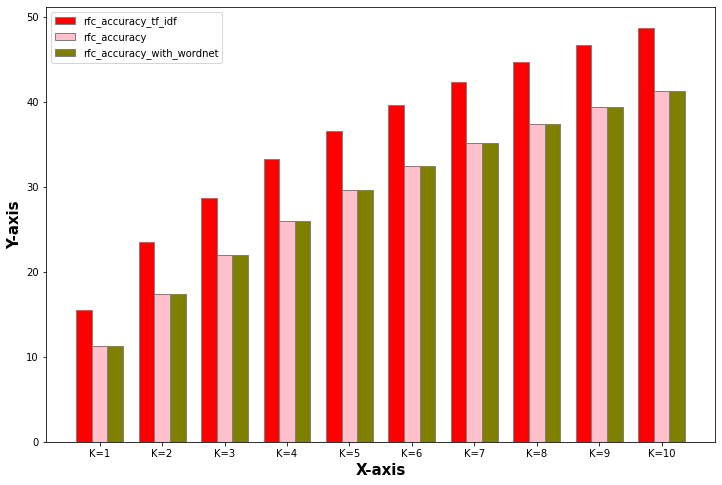

In [69]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# Set position of bar on X axis
br1 = np.arange(10)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]


# Make the plot
plt.bar(br1, rfc_accuracy_tf_idf_avg, color ='r', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy_tf_idf')
plt.bar(br2, rfc_accuracy_avg, color ='pink', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy')
plt.bar(br3, rfc_accuracy_with_wordnet_avg, color ='olive', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy_with_wordnet')

# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(10)],
        ['K=1', 'K=2', 'K=3', 'K=4', 'K=5','K=6', 'K=7', 'K=8', 'K=9', 'K=10'])

# plt.title('Accuracy : Random Forest - TF-IDF Vs Word2Vec with WordNet Vs Word2Vec without WordNet')

plt.legend()

# plt.show()

plt.savefig('Accuracy_Random_Forest_TF-IDF_Vs_Word2Vec_with_or_without_WordNet_bar.png')

In [70]:
rfc_accuracy_tf_idf_avg_rank = []
rfc_accuracy_avg_rank = []
rfc_accuracy_with_wordnet_avg_rank = []

rfc_accuracy_tf_idf_avg_rank.append(rfc_accuracy_tf_idf_avg[0])
rfc_accuracy_tf_idf_avg_rank.append(rfc_accuracy_tf_idf_avg[4])
rfc_accuracy_tf_idf_avg_rank.append(rfc_accuracy_tf_idf_avg[9])

rfc_accuracy_avg_rank.append(rfc_accuracy_avg[0])
rfc_accuracy_avg_rank.append(rfc_accuracy_avg[4])
rfc_accuracy_avg_rank.append(rfc_accuracy_avg[9])

rfc_accuracy_with_wordnet_avg_rank.append(rfc_accuracy_with_wordnet_avg[0])
rfc_accuracy_with_wordnet_avg_rank.append(rfc_accuracy_with_wordnet_avg[4])
rfc_accuracy_with_wordnet_avg_rank.append(rfc_accuracy_with_wordnet_avg[9])

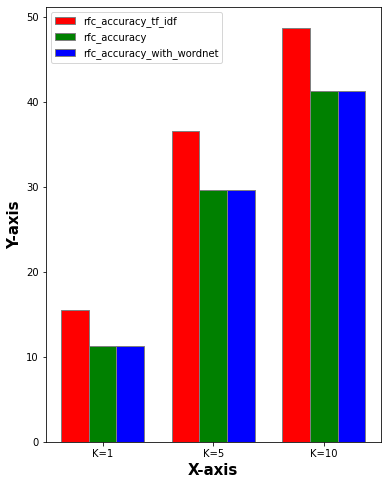

In [71]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(6, 8))

# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]


# Make the plot
plt.bar(br1, rfc_accuracy_tf_idf_avg_rank, color ='r', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy_tf_idf')
plt.bar(br2, rfc_accuracy_avg_rank, color ='g', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy')
plt.bar(br3, rfc_accuracy_with_wordnet_avg_rank, color ='b', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy_with_wordnet')

# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['K=1','K=5', 'K=10'])

# plt.title('Accuracy (Rank 1, 5 and 10): Random Forest - TF-IDF Vs Word2Vec with WordNet Vs Word2Vec without WordNet')

plt.legend()

# plt.show()

plt.savefig('Accuracy_Random_Forest_TF-IDF_Vs_Word2Vec_with_or_without_WordNet_bar_rank.png')

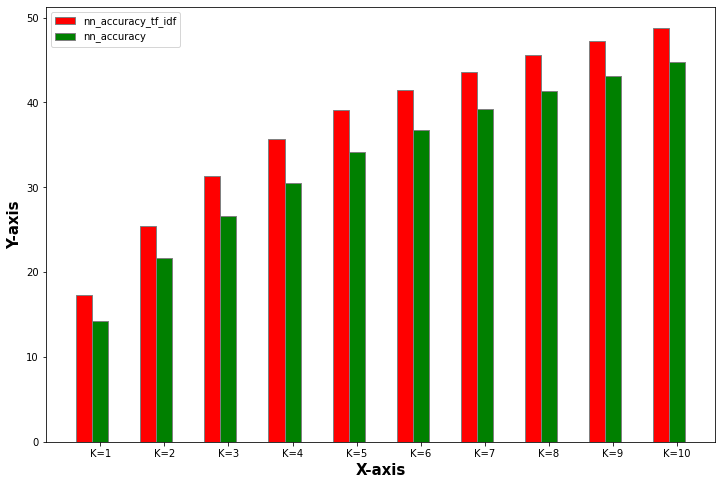

In [72]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# Set position of bar on X axis
br1 = np.arange(10)
br2 = [x + barWidth for x in br1]


# Make the plot
plt.bar(br1, nn_accuracy_tf_idf_avg, color ='r', width = barWidth,
        edgecolor ='grey', label ='nn_accuracy_tf_idf')
plt.bar(br2, nn_accuracy_avg, color ='g', width = barWidth,
        edgecolor ='grey', label ='nn_accuracy')

# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(10)],
        ['K=1', 'K=2', 'K=3', 'K=4', 'K=5','K=6', 'K=7', 'K=8', 'K=9', 'K=10'])

# plt.title('Accuracy : Bidirectional Neural Network - TF-IDF Vs Word2Vec with WordNet Vs Word2Vec without WordNet')

plt.legend()

# plt.show()

plt.savefig('Accuracy_Bidirectional_Neural_Network_TF-IDF_Vs_Word2Vec_bar.png')

In [73]:
nn_accuracy_tf_idf_avg_rank = []
nn_accuracy_avg_rank = []

nn_accuracy_tf_idf_avg_rank.append(nn_accuracy_tf_idf_avg[0])
nn_accuracy_tf_idf_avg_rank.append(nn_accuracy_tf_idf_avg[4])
nn_accuracy_tf_idf_avg_rank.append(nn_accuracy_tf_idf_avg[9])

nn_accuracy_avg_rank.append(nn_accuracy_avg[0])
nn_accuracy_avg_rank.append(nn_accuracy_avg[4])
nn_accuracy_avg_rank.append(nn_accuracy_avg[9])

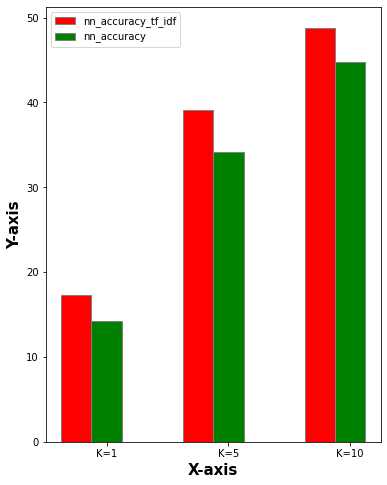

In [74]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(6, 8))

# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]


# Make the plot
plt.bar(br1, nn_accuracy_tf_idf_avg_rank, color ='r', width = barWidth,
        edgecolor ='grey', label ='nn_accuracy_tf_idf')
plt.bar(br2, nn_accuracy_avg_rank, color ='g', width = barWidth,
        edgecolor ='grey', label ='nn_accuracy')

# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['K=1', 'K=5', 'K=10'])

# plt.title('Accuracy (Rank 1, 5 and 10 ) : Bidirectional Neural Network - TF-IDF Vs Word2Vec')

plt.legend()

# plt.show()

plt.savefig('Accuracy_Bidirectional_Neural_Network_TF-IDF_Vs_Word2Vec_bar_rank.png')

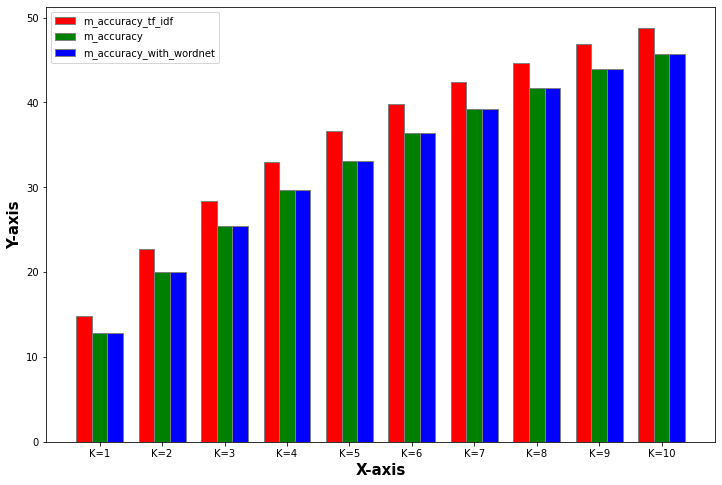

In [75]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# Set position of bar on X axis
br1 = np.arange(10)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]


# Make the plot
plt.bar(br1, m_accuracy_tf_idf_avg, color ='r', width = barWidth,
        edgecolor ='grey', label ='m_accuracy_tf_idf')
plt.bar(br2, m_accuracy_avg, color ='g', width = barWidth,
        edgecolor ='grey', label ='m_accuracy')
plt.bar(br3, m_accuracy_with_wordnet_avg, color ='b', width = barWidth,
        edgecolor ='grey', label ='m_accuracy_with_wordnet')

# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(10)],
        ['K=1', 'K=2', 'K=3', 'K=4', 'K=5','K=6', 'K=7', 'K=8', 'K=9', 'K=10'])

# plt.title('Accuracy : MLP Classifier - TF-IDF Vs Word2Vec with WordNet Vs Word2Vec without WordNet')

plt.legend()

# plt.show()

plt.savefig('Accuracy_MLP_Classifier_TF-IDF_Vs_Word2Vec_with_or_without_WordNet_bar.png')

In [76]:
m_accuracy_tf_idf_avg_rank = []
m_accuracy_avg_rank = []
m_accuracy_with_wordnet_avg_rank = []

m_accuracy_tf_idf_avg_rank.append(m_accuracy_tf_idf_avg[0])
m_accuracy_tf_idf_avg_rank.append(m_accuracy_tf_idf_avg[4])
m_accuracy_tf_idf_avg_rank.append(m_accuracy_tf_idf_avg[9])

m_accuracy_avg_rank.append(m_accuracy_avg[0])
m_accuracy_avg_rank.append(m_accuracy_avg[4])
m_accuracy_avg_rank.append(m_accuracy_avg[9])

m_accuracy_with_wordnet_avg_rank.append(m_accuracy_with_wordnet_avg[0])
m_accuracy_with_wordnet_avg_rank.append(m_accuracy_with_wordnet_avg[4])
m_accuracy_with_wordnet_avg_rank.append(m_accuracy_with_wordnet_avg[9])

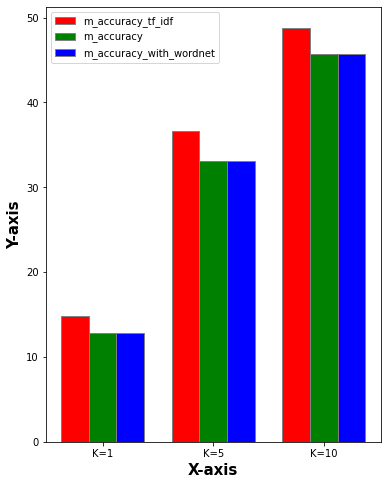

In [77]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(6, 8))

# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]


# Make the plot
plt.bar(br1, m_accuracy_tf_idf_avg_rank, color ='r', width = barWidth,
        edgecolor ='grey', label ='m_accuracy_tf_idf')
plt.bar(br2, m_accuracy_avg_rank, color ='g', width = barWidth,
        edgecolor ='grey', label ='m_accuracy')
plt.bar(br3, m_accuracy_with_wordnet_avg_rank, color ='b', width = barWidth,
        edgecolor ='grey', label ='m_accuracy_with_wordnet')

# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['K=1', 'K=5', 'K=10'])

# plt.title('Accuracy (Rank 1, 5 and 10): MLP Classifier - TF-IDF Vs Word2Vec with WordNet Vs Word2Vec without WordNet')

plt.legend()

# plt.show()

plt.savefig('Accuracy_MLP_Classifier_TF-IDF_Vs_Word2Vec_with_or_without_WordNet_bar_rank.png')

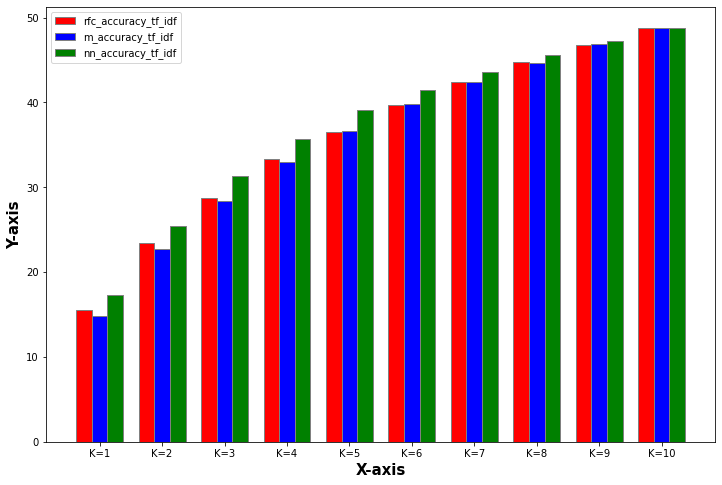

In [78]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# Set position of bar on X axis
br1 = np.arange(10)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, rfc_accuracy_tf_idf_avg, color ='r', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy_tf_idf')
plt.bar(br2, m_accuracy_tf_idf_avg, color ='b', width = barWidth,
        edgecolor ='grey', label ='m_accuracy_tf_idf')
plt.bar(br3, nn_accuracy_tf_idf_avg, color ='g', width = barWidth,
        edgecolor ='grey', label ='nn_accuracy_tf_idf')

# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(10)],
        ['K=1', 'K=2', 'K=3', 'K=4', 'K=5','K=6', 'K=7', 'K=8', 'K=9', 'K=10'])

# plt.title('Accuracy: BiDirectional Neural Network Vs MLP Classifier Vs Random Forest')

plt.legend()

# plt.show()

plt.savefig('Accuracy_BiDirectional_Neural_Network_Vs_MLP_Classifier_Vs_Random_Forest_tf_idf_bar.png')

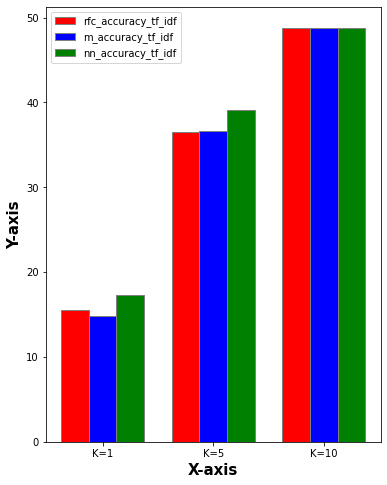

In [79]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(6, 8))

# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, rfc_accuracy_tf_idf_avg_rank, color ='r', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy_tf_idf')
plt.bar(br2, m_accuracy_tf_idf_avg_rank, color ='b', width = barWidth,
        edgecolor ='grey', label ='m_accuracy_tf_idf')
plt.bar(br3, nn_accuracy_tf_idf_avg_rank, color ='g', width = barWidth,
        edgecolor ='grey', label ='nn_accuracy_tf_idf')

# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['K=1', 'K=5', 'K=10'])

# plt.title('Accuracy (Rank 1, 5 and 10): BiDirectional Neural Network Vs MLP Classifier Vs Random Forest')

plt.legend()

# plt.show()

plt.savefig('Accuracy_BiDirectional_Neural_Network_Vs_MLP_Classifier_Vs_Random_Forest_tf_idf_bar_rank.png')

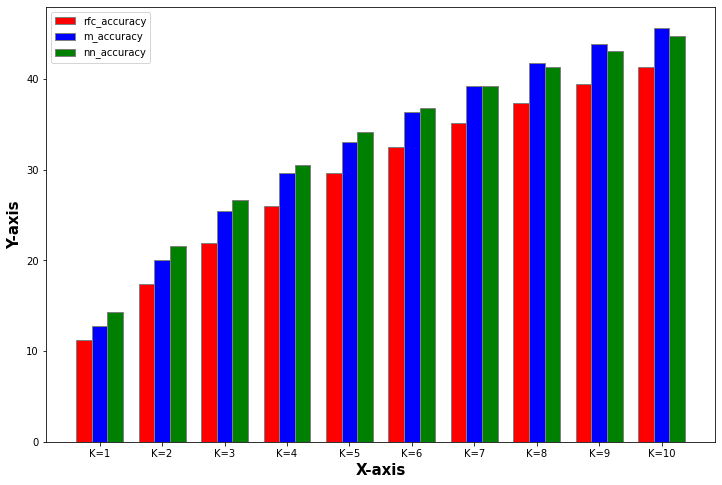

In [80]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# Set position of bar on X axis
br1 = np.arange(10)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, rfc_accuracy_avg, color ='r', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy')
plt.bar(br2, m_accuracy_avg, color ='b', width = barWidth,
        edgecolor ='grey', label ='m_accuracy')
plt.bar(br3, nn_accuracy_avg, color ='g', width = barWidth,
        edgecolor ='grey', label ='nn_accuracy')


# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(10)],
        ['K=1', 'K=2', 'K=3', 'K=4', 'K=5','K=6', 'K=7', 'K=8', 'K=9', 'K=10'])

# plt.title('Accuracy: BiDirectional Neural Network Vs MLP Classifier Vs Random Forest')

plt.legend()

# plt.show()

plt.savefig('Accuracy_BiDirectional_Neural_Network_Vs_MLP_Classifier_Vs_Random_Forest_word2vec_bar.png')

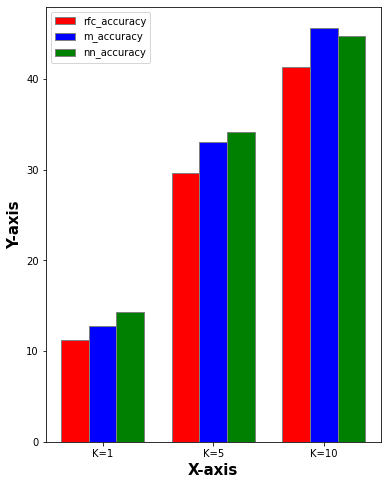

In [81]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(6, 8))

# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, rfc_accuracy_avg_rank, color ='r', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy')
plt.bar(br2, m_accuracy_avg_rank, color ='b', width = barWidth,
        edgecolor ='grey', label ='m_accuracy')
plt.bar(br3, nn_accuracy_avg_rank, color ='g', width = barWidth,
        edgecolor ='grey', label ='nn_accuracy')


# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['K=1', 'K=5', 'K=10'])

# plt.title('Accuracy (Rank 1, 5 and 10): BiDirectional Neural Network Vs MLP Classifier Vs Random Forest')

plt.legend()

# plt.show()

plt.savefig('Accuracy_BiDirectional_Neural_Network_Vs_MLP_Classifier_Vs_Random_Forest_word2vec_bar_rank.png')

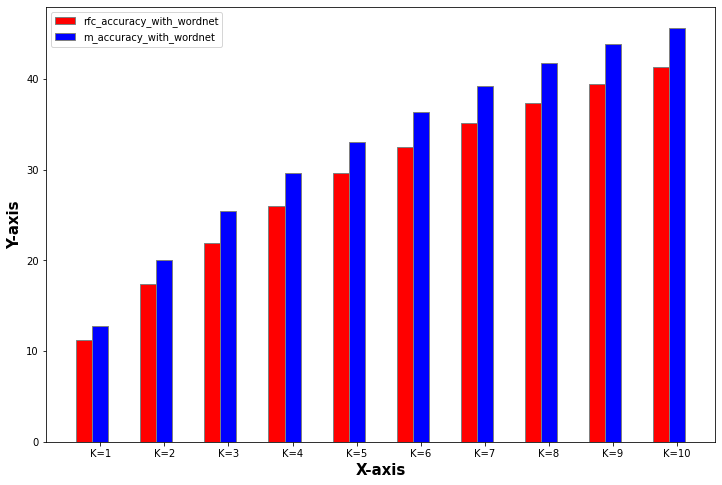

In [82]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(10)
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, rfc_accuracy_with_wordnet_avg, color ='r', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy_with_wordnet')
plt.bar(br2, m_accuracy_with_wordnet_avg, color ='b', width = barWidth,
        edgecolor ='grey', label ='m_accuracy_with_wordnet')
 
# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(10)],
        ['K=1', 'K=2', 'K=3', 'K=4', 'K=5','K=6', 'K=7', 'K=8', 'K=9', 'K=10'])

# plt.title('Accuracy:MLP Classifier Vs Random Forest')
 
plt.legend()

# plt.show()

plt.savefig('Accuracy_MLP_Classifier_Vs_Random_Forest_wordnet_bar.png')

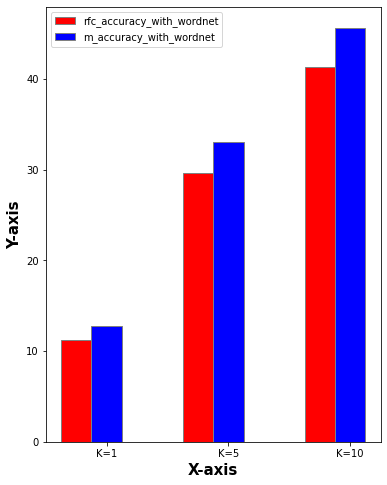

In [83]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(6, 8))
 
# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, rfc_accuracy_with_wordnet_avg_rank, color ='r', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy_with_wordnet')
plt.bar(br2, m_accuracy_with_wordnet_avg_rank, color ='b', width = barWidth,
        edgecolor ='grey', label ='m_accuracy_with_wordnet')
 
# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['K=1', 'K=5', 'K=10'])

# plt.title('Accuracy (Rank 1, 5 and 10): MLP Classifier Vs Random Forest')
 
plt.legend()

# plt.show()

plt.savefig('Accuracy_MLP_Classifier_Vs_Random_Forest_wordnet_bar_rank.png')

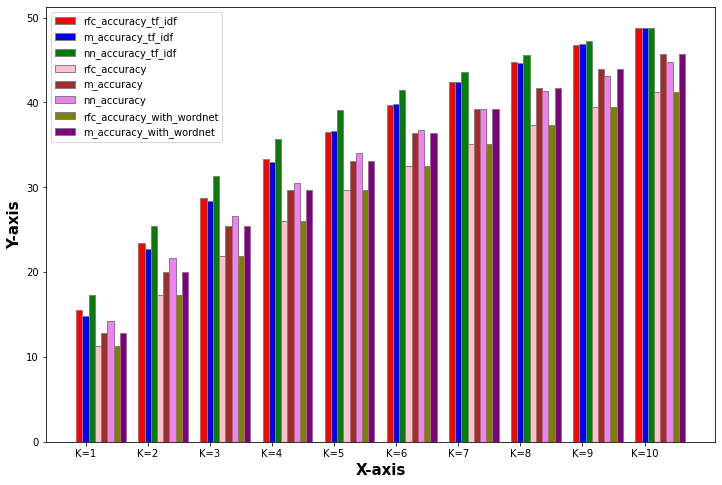

In [84]:
# set width of bar
barWidth = 0.10
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(10)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]
br7 = [x + barWidth for x in br6]
br8 = [x + barWidth for x in br7]


# Make the plot
plt.bar(br1, rfc_accuracy_tf_idf_avg, color ='r', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy_tf_idf')
plt.bar(br2, m_accuracy_tf_idf_avg, color ='b', width = barWidth,
        edgecolor ='grey', label ='m_accuracy_tf_idf')
plt.bar(br3, nn_accuracy_tf_idf_avg, color ='g', width = barWidth,
        edgecolor ='grey', label ='nn_accuracy_tf_idf')
plt.bar(br4, rfc_accuracy_avg, color ='pink', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy')
plt.bar(br5, m_accuracy_avg, color ='brown', width = barWidth,
        edgecolor ='grey', label ='m_accuracy')
plt.bar(br6, nn_accuracy_avg, color ='violet', width = barWidth,
        edgecolor ='grey', label ='nn_accuracy')
plt.bar(br7, rfc_accuracy_with_wordnet_avg, color ='olive', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy_with_wordnet')
plt.bar(br8, m_accuracy_with_wordnet_avg, color ='purple', width = barWidth,
        edgecolor ='grey', label ='m_accuracy_with_wordnet')
 
# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(10)],
        ['K=1', 'K=2', 'K=3', 'K=4', 'K=5','K=6', 'K=7', 'K=8', 'K=9', 'K=10'])

# plt.title('Accuracy: BiDirectional Neural Network Vs MLP Classifier Vs Random Forest')
 
plt.legend()

# plt.show()

plt.savefig('Accuracy_BiDirectional_Neural_Network_Vs_MLP_Classifier_Vs_Random_Forest_all_bar.png')

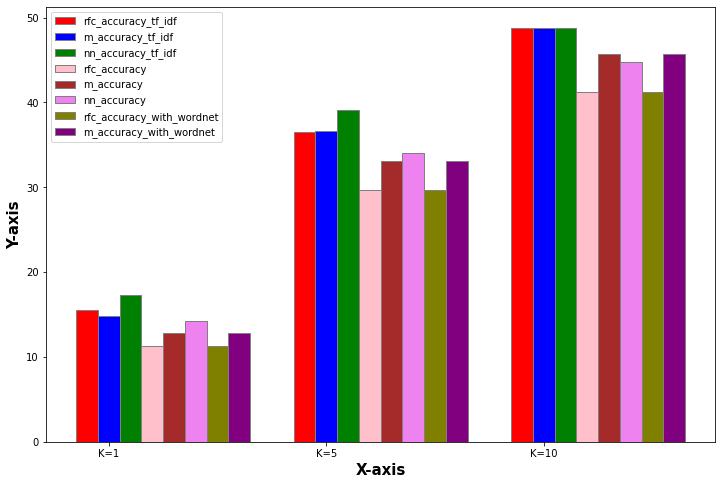

In [85]:
# set width of bar
barWidth = 0.10
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]
br7 = [x + barWidth for x in br6]
br8 = [x + barWidth for x in br7]


# Make the plot
plt.bar(br1, rfc_accuracy_tf_idf_avg_rank, color ='r', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy_tf_idf')
plt.bar(br2, m_accuracy_tf_idf_avg_rank, color ='b', width = barWidth,
        edgecolor ='grey', label ='m_accuracy_tf_idf')
plt.bar(br3, nn_accuracy_tf_idf_avg_rank, color ='g', width = barWidth,
        edgecolor ='grey', label ='nn_accuracy_tf_idf')
plt.bar(br4, rfc_accuracy_avg_rank, color ='pink', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy')
plt.bar(br5, m_accuracy_avg_rank, color ='brown', width = barWidth,
        edgecolor ='grey', label ='m_accuracy')
plt.bar(br6, nn_accuracy_avg_rank, color ='violet', width = barWidth,
        edgecolor ='grey', label ='nn_accuracy')
plt.bar(br7, rfc_accuracy_with_wordnet_avg_rank, color ='olive', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy_with_wordnet')
plt.bar(br8, m_accuracy_with_wordnet_avg_rank, color ='purple', width = barWidth,
        edgecolor ='grey', label ='m_accuracy_with_wordnet')
 
# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['K=1', 'K=5', 'K=10'])

# plt.title('Accuracy (Rank 1, 5 and 10): BiDirectional Neural Network Vs MLP Classifier Vs Random Forest')
 
plt.legend()

# plt.show()

plt.savefig('Accuracy_BiDirectional_Neural_Network_Vs_MLP_Classifier_Vs_Random_Forest_all_bar_rank.png')

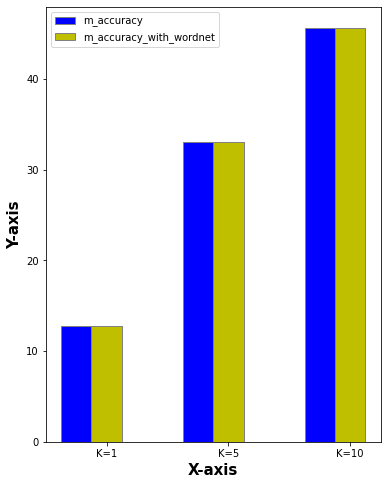

In [86]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(6, 8))
 
# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]


# Make the plot
plt.bar(br1, m_accuracy_avg_rank, color ='b', width = barWidth,
        edgecolor ='grey', label ='m_accuracy')
plt.bar(br2, m_accuracy_with_wordnet_avg_rank, color ='y', width = barWidth,
        edgecolor ='grey', label ='m_accuracy_with_wordnet')
 
# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['K=1', 'K=5', 'K=10'])

# plt.title('Accuracy with or without wordnet (Rank 1, 5 and 10): MLP Classifier')
 
plt.legend()

# plt.show()
plt.savefig('Accuracy_MLP_Classifier_with_or_without_wordnet_bar_rank.png')

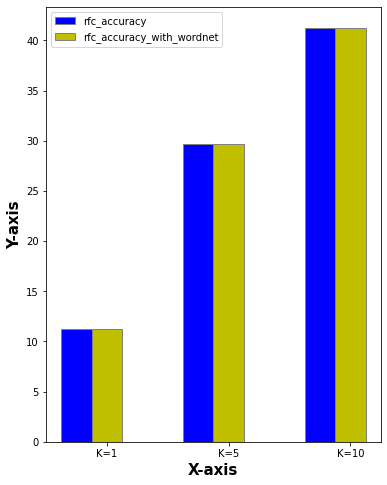

In [87]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(6, 8))
 
# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]


# Make the plot
plt.bar(br1, rfc_accuracy_avg_rank, color ='b', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy')
plt.bar(br2, rfc_accuracy_with_wordnet_avg_rank, color ='y', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy_with_wordnet')
 
# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['K=1', 'K=5', 'K=10'])

# plt.title('Accuracy with or without wordnet (Rank 1, 5 and 10): BiDirectional Neural Network')
 
plt.legend()

# plt.show()

plt.savefig('Accuracy_Random_Forest_with_or_without_wordnet_bar_rank.png')

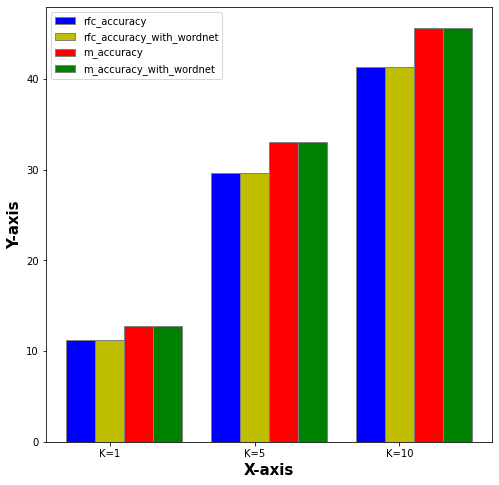

In [88]:
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(8, 8))
 
# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]


# Make the plot
plt.bar(br1, rfc_accuracy_avg_rank, color ='b', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy')
plt.bar(br2, rfc_accuracy_with_wordnet_avg_rank, color ='y', width = barWidth,
        edgecolor ='grey', label ='rfc_accuracy_with_wordnet')

plt.bar(br3, m_accuracy_avg_rank, color ='r', width = barWidth,
        edgecolor ='grey', label ='m_accuracy')
plt.bar(br4, m_accuracy_with_wordnet_avg_rank, color ='g', width = barWidth,
        edgecolor ='grey', label ='m_accuracy_with_wordnet')
 
# Adding Xticks
plt.xlabel('X-axis', fontweight ='bold', fontsize = 15)
plt.ylabel('Y-axis', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['K=1', 'K=5', 'K=10'])

# plt.title('Accuracy with or without wordnet (Rank 1, 5 and 10): BiDirectional Neural Network Vs MLP Classifier')
 
plt.legend()

# plt.show()

plt.savefig('Accuracy_Random_Forest_Vs_MLP_Classifier_with_or_without_wordnet_bar_rank.png')

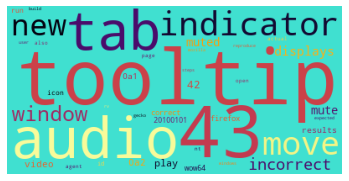

In [89]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

d = {w: f for w, f in
     zip(['firefox', 'tab','window', 'icon','new','results','windows','open','rv','user','mozilla','id','agent',
     'tooltip','build','audio','page','move','nt','indicator','gecko','video','also','correct','reproduce',
     'wow64','expected','incorrect','displays','actual','43','0a1','run','42','steps','20100101','play',
     'muted','0a2','mute'],
    [0.08, 0.3, 0.2, 0.07, 0.23, 0.09, 0.04, 0.05, 0.04, 0.04, 0.04, 0.06, 0.05, 0.39, 0.04, 0.33, 0.05, 0.28, 
    0.05, 0.29, 0.04, 0.1, 0.05, 0.08, 0.04, 0.08, 0.04, 0.2, 0.18, 0.05, 0.35, 0.09, 0.07, 0.12, 0.04, 0.08, 
    0.11, 0.15, 0.1, 0.14])}
wordcloud = WordCloud(background_color='turquoise', colormap='inferno', prefer_horizontal=1)
wordcloud.generate_from_frequencies(frequencies=d)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

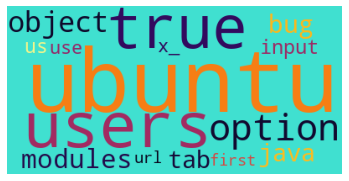

In [90]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

d = {w: f for w, f in
     zip(['ubuntu', 'users', 'true', 'option', 'object', 'modules', 'bug','java', 'tab', 'input', 'us', 'use', 
          'x_', 'first', 'url'],
    [0.03651848924087011, 0.029777380991612513, 0.025905891428369982, 0.024146471222285155, 0.024059586868839907, 
     0.02293035632761902, 0.021869748730702968, 0.020939467248671906, 0.020541274187440197, 0.020126839153104377, 
     0.018598075157426956, 0.017422983793982754, 0.01737882046718786, 0.017278595910240342,  0.017203761116098493])}
wordcloud = WordCloud(background_color='turquoise', colormap='inferno', prefer_horizontal=1)
wordcloud.generate_from_frequencies(frequencies=d)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wordCloudResults.png')
plt.show()

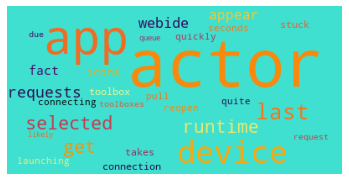

In [91]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

d = {w: f for w, f in
     zip(['actor', 'app', 'device', 'last', 'get', 'selected', 'runtime', 'requests', 'webide', 'appear', 'fact', 
          'icons','connection', 'takes', 'toolbox', 'stuck', 'reopen', 'pull', 'connecting', 'seconds', 'quite', 
          'quickly', 'launching', 'due','request', 'toolboxes', 'queue', 'likely', '__int'],
         [0.07071525923898643, 0.030279679873516752, 0.009689926550145507, 0.003793172051216064, 0.00254099704900428, 
          0.002441910521809218, 0.0021629162072491753, 0.0015443955144071341, 0.0014209360585410171, 
          0.0012662152892669654, 0.0010605925794445593, 0.000815286477851604, 0.0007331947705021759, 
          0.000673049499098092, 0.00067296601792968, 0.0006500024189134574, 0.0005913461011158607, 
          0.0005836965918540423,  0.0005426361497607821, 0.0005006002185978206, 0.0004927981545728546, 
          0.0004720169307970151, 0.0004624771621915017, 0.00039807685333888504, 0.00038233716349025634, 
          0.00038233716349025634, 0.00030960878631248274, 0.0002857327419832048, 0.0])}

wordcloud = WordCloud(background_color='turquoise', colormap='inferno', prefer_horizontal=1)
wordcloud.generate_from_frequencies(frequencies=d)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wordCloudResults_mf_9_rf.png')
plt.show()

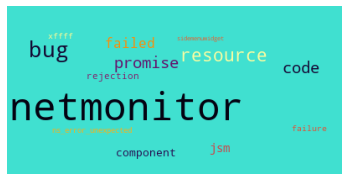

In [92]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

d = {w: f for w, f in
     zip(['netmonitor', 'bug', 'resource', 'promise', 'code', 'failed', 'jsm', 'component', 'rejection', 'xffff', 'failure', 'ns_error_unexpected',
     'sidemenuwidget', '__int'],
    [0.049106675439572506, 0.00597758691960389, 0.003736326694271512, 0.0031969263806178147, 0.0031038413204947683, 0.0020881101701336544,
0.0015517746299717257, 0.0012956304593081823, 0.0008189400947799912, 0.0006260367715957016, 0.0005825481520243568, 0.0005196466356325949,
0.0003243854369344503, 0.0])}

wordcloud = WordCloud(background_color='turquoise', colormap='inferno', prefer_horizontal=1)
wordcloud.generate_from_frequencies(frequencies=d)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wordCloudResults_mf_8_rf.png')
plt.show()

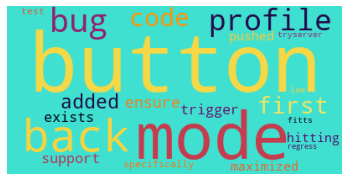

In [93]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

d = {w: f for w, f in
     zip(['button', 'mode', 'back', 'bug', 'profile', 'code', 'first', 'added', 'ensure', 'exists', 'support', 'trigger', 'maximized',
     'hitting', 'pushed', 'specifically', 'test', 'tryserver', 'fitts', 'law', 'regress', '__int'],
    [0.07495776486310282, 0.04415322902016924, 0.016591924665485362, 0.010819248704126871, 0.008426058121659587, 
0.006014563302152848, 0.005059781028591117, 0.0032606624248911076, 0.0018468361354483011, 0.0016030293326104858, 
0.0015660229035456554, 0.0015177491719811221, 0.0011706862415966843, 0.0011592972800890163, 0.0010839195931284596, 
0.0009654796644435536, 0.0008752603174255275, 0.0007750979331746348,  0.0007367282728615663, 0.0006746321589445542,
0.0005663453441475845, 0.0])}
wordcloud = WordCloud(background_color='turquoise', colormap='inferno', prefer_horizontal=1)
wordcloud.generate_from_frequencies(frequencies=d)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wordCloudResults_mf_7_mlp.png')
plt.show()

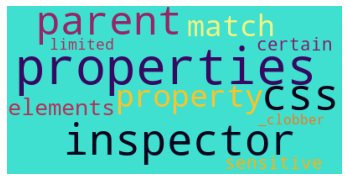

In [94]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

d = {w: f for w, f in
     zip(['properties', 'inspector', 'css', 'parent', 'property', 'match', 'elements','certain', 'sensitive', 
          'limited', '_clobber'],
    [0.006902906801621644, 0.004891664152537237, 0.00482604781635709, 0.00449086261658101, 0.004203361815966984, 
     0.0036570495904032878, 0.002088192248238848, 0.001145774949174731, 0.001137856395409251, 0.0008520012534539346, 
     0.0006891470268743567, 0.0])}
wordcloud = WordCloud(background_color='turquoise', colormap='inferno', prefer_horizontal=1)
wordcloud.generate_from_frequencies(frequencies=d)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wordCloudResults_mf_4_mlp.png')
plt.show()

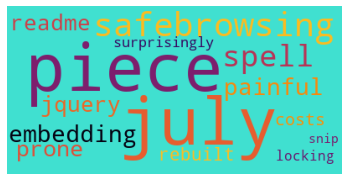

In [95]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

d = {w: f for w, f in
     zip(['piece', 'july', 'safebrowsing', 'spell', 'embedding', 'painful', 'prone', 'jquery', 'readme', 'rebuilt', 
          'costs', 'surprisingly', 'locking', 'snip', 'wins', 'accomplish', 'urlbarbindings', 'encodings'],
    [0.03281542226186269, 0.03272765833859264, 0.032663635714616154, 0.026194802065582133, 
    0.026119825206737068, 0.025763154078276933, 0.024270109766512695, 0.02190240070661593, 
    0.021159489721821963, 0.01318943974631702, 0.011570324032240693, 0.011381094254297239, 
    0.01012543869291757, 0.009405631143557535])}
wordcloud = WordCloud(background_color='turquoise', colormap='inferno', prefer_horizontal=1)
wordcloud.generate_from_frequencies(frequencies=d)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wordCloudResults_mf_5_nn.png')
plt.show()

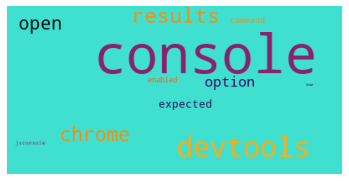

In [96]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

d = {w: f for w, f in
     zip(['console', 'devtools', 'results', 'chrome', 'open', 'option', 'expected', 'command', 'enabled', 'jsconsole', 'true'],
    [0.3659577134182525, 0.019426130938377143, 0.008664038278078781, 0.007601786529601536, 
    0.005978618193476514, 0.0037095486926454224, 0.0019085297498435115, 0.0010724847224814996, 
    0.0009609244459471314, 0.0003236051109529047, 6.22470483717056e-05])}
wordcloud = WordCloud(background_color='turquoise', colormap='inferno', prefer_horizontal=1)
wordcloud.generate_from_frequencies(frequencies=d)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wordCloudResults_mf_6_rf.png')
plt.show()

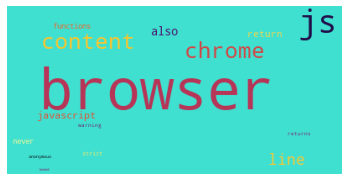

In [97]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

d = {w: f for w, f in
     zip(['browser', 'js', 'content', 'chrome', 'line', 'also', 'javascript', 'return', 'functions', 'never', 
    'strict', 'warning', 'returns', 'anonymous', 'looked', 'warnings', '_blank', '_clobber', '_depend'],
    [0.1503642669116318, 0.02017315428491887, 0.007443139880641706, 0.00734954809461839, 
    0.0029358677087064143, 0.0015252601458839957, 0.001002833568741348,  0.0008518012894063532, 
    0.0005087359285396105, 0.0004544421314825656, 0.00024434100430898104, 0.00020477398763340475, 
    0.00017813619611110418, 0.00011836197701944449, 9.17419894243273e-05, 1.0259385551573711e-05, 0.0, 0.0, 0.0])}
wordcloud = WordCloud(background_color='turquoise', colormap='inferno', prefer_horizontal=1)
wordcloud.generate_from_frequencies(frequencies=d)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wordCloudResults_mf_5_rf.png')
plt.show()